>> # **Machine Learning 2 - Final Project**
>> ## **Clustering Diamonds for Quality Assessment**
>> ### By: Niv Levi & Sarah Hazziza
>> ### Lecturer: Phd. Chen Hagag


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import Paired, plasma
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import plotly.graph_objects as go

csv_file_path = "ProjectData_diamonds_lab_natural1.csv"

df = pd.read_csv(csv_file_path)

In [4]:
df.columns

Index(['id', 'itemstatusid', 'cut', 'img', 'oim', 'itemCode', 'link',
       'lightPerf', 'polish', 'symm', 'depth', 'table', 'crownAngle', 'star',
       'pavilion', 'crown', 'lowerGirdle', 'measur', 'culet', 'fluor',
       'girdle', 'IsDiamondInShoppingCart', 'IsAllRingBuildersCompleteDiamond',
       'IsDiamondInWishlist', 'ShowDiamondSubscription', 'PriceAlert',
       'eyeClean', 'buyEnable', 'certType', 'code', 'price'],
      dtype='object')

In [5]:
df.head()

id  itemstatusid     cut   
0  4408129             1   Ideal  \
1  4408140             1   Ideal   
2  4439738             1   Ideal   
3  4439742             1   Ideal   
4  4439743             1   Ideal   

                                                 img  oim          itemCode   
0  /photos/2021/06/01/th500/Hearts-and-Arrows-Rou...    0  AGS-104102899019  \
1  /photos/2021/06/01/th500/Hearts-and-Arrows-Rou...    0  AGS-104113380011   
2  /photos/2021/10/01/th500/Hearts-and-Arrows-Rou...    0  AGS-104115731026   
3  /photos/2021/10/01/th500/Hearts-and-Arrows-Rou...    0  AGS-104115731033   
4  /photos/2021/10/01/th500/Hearts-and-Arrows-Rou...    0  AGS-104115731036   

                                                link lightPerf polish   symm   
0  /loose-diamonds/1.15-carat-g-color-vs1-clarity...     Ideal  Ideal  Ideal  \
1  /loose-diamonds/1.155-carat-j-color-vvs1-clari...     Ideal  Ideal  Ideal   
2  /loose-diamonds/1.015-carat-j-color-vvs1-clari...     Ideal  Ideal  Ideal   
3  /loose-diamonds/1.083-carat-j-color-vvs2-clari...     Ideal  Ideal  Ideal   
4  /loose-diamonds/1.13-carat-j-color-vvs2-clarit...     Ideal  Ideal  Ideal   

   ...  IsDiamondInShoppingCart  IsAllRingBuildersCompleteDiamond   
0  ...                    False                              True  \
1  ...                    False                              True   
2  ...                    False                              True   
3  ...                    False                              True   
4  ...                    False                              True   

   IsDiamondInWishlist  ShowDiamondSubscription  PriceAlert  eyeClean   
0                False                    False        True       Yes  \
1                False                    False        True       Yes   
2                False                    False        True       Yes   
3                False                    False        True       Yes   
4                False                    False        True       Yes   

   buyEnable certType              code price  
0       True      AGS  AGS-104102899019  9450  
1       True      AGS  AGS-104113380011  5695  
2       True      AGS  AGS-104115731026  4995  
3       True      AGS  AGS-104115731033  4950  
4       True      AGS  AGS-104115731036  5175  

[5 rows x 31 columns]

> # **Data Cleaning**

In [6]:
# Extracting information from the 'link' column
df['Color'] = df['link'].apply(lambda x: x.split('-')[3].upper())
df['Clarity'] = df['link'].apply(lambda x: x.split('-')[5].upper())
df['Carat'] = df['link'].apply(lambda x: x.split('/')[2].split('-')[0]).str.replace('carat', '').astype(float)

In [7]:
df['certType']=df['itemCode'].astype(str).replace(r'\d+','',regex=True).str.replace('-','')
df = df[df['certType'] != 'AGS']
df['Natural']=df['certType'].apply(lambda x: 0 if 'LG' in x else 1)
df['Pointed Culet'] = df['culet'].apply(lambda x: 0 if pd.isna(x) or x == 'None' or x is np.nan else 1)
df['certType'] = df['certType'].apply(lambda x: x.replace('LG',''))
df[['Length','Width','Depth']] = df['measur'].str.split('x',expand=True).astype(float)
df['Fluorescence'] = df['fluor'].fillna('None')
df.drop(columns=['itemstatusid','oim','culet','fluor','img','code','measur','IsDiamondInShoppingCart','IsAllRingBuildersCompleteDiamond','IsDiamondInWishlist','ShowDiamondSubscription','PriceAlert','buyEnable'],inplace=True)
df['cut']=df['cut'].str.strip()

In [8]:
df['girdle'] = df['girdle'].fillna(df['girdle'].value_counts().idxmax())
df['girdle']=df['girdle'].str.lower().str.replace('to', '-').str.replace('stk','slightly thick').str.replace('slighty','slightly').str.replace('extr.','extremely').str.replace('faceted','').str.replace('(','').str.replace(')','').str.replace('thn','thin').str.replace(r'\bmed\b', 'medium', regex=True).str.strip()
df[['Thinest_Girdle', 'Thickest_Girdle']] = df['girdle'].str.split('-', n=1, expand=True)
df['Thinest_Girdle'] = df['Thinest_Girdle'].str.strip()
df['Thickest_Girdle'] = df['Thickest_Girdle'].str.strip()
df['Thickest_Girdle'].fillna(df['Thinest_Girdle'], inplace=True)
df.drop(columns=['girdle'],inplace=True)

In [9]:
# Calculate the number of NaN values in each column
na_count_per_column = df.isna().sum()
print(na_count_per_column)

id                 0
cut                1
itemCode           0
link               0
lightPerf          0
polish             0
symm               0
depth              0
table              0
crownAngle         0
star               0
pavilion           0
crown              0
lowerGirdle        0
eyeClean           7
certType           0
price              0
Color              0
Clarity            0
Carat              0
Natural            0
Pointed Culet      0
Length             0
Width              0
Depth              0
Fluorescence       0
Thinest_Girdle     0
Thickest_Girdle    0
dtype: int64


In [10]:
df.rename(columns={'depth': 'Depth%', 'table': 'Table%', 'star':'Star%','pavilion':'Pavilion_Angle','crown':'Crown%','lowerGirdle':'Lower_Girdle%','lightPerf':'Light_Performance','symm':'Symmetry','certType':'Certification'},inplace=True)
df.columns = df.columns.str.title()

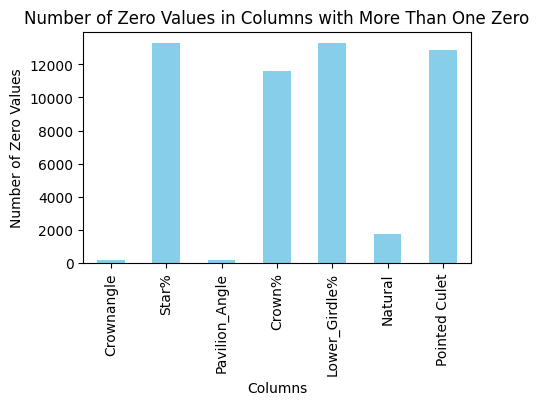

In [11]:
# Count zero values in each column
zero_counts = df.eq(0).sum()

# Filter columns with more than one zero
zero_counts_filtered = zero_counts[zero_counts > 1]

# Visualize zero counts
plt.figure(figsize=(5, 3))
zero_counts_filtered.plot(kind='bar', color='skyblue')
plt.title('Number of Zero Values in Columns with More Than One Zero')
plt.xlabel('Columns')
plt.ylabel('Number of Zero Values')
plt.xticks(rotation=90)
plt.show()

In [12]:
#Remove all 0s from the Crown and Pavillion Angle
df = df[(df['Crownangle'] != 0)]
df = df[(df['Pavilion_Angle'] != 0)]

#Remove all rows with missing Cut and Eyeclean
df = df[df['Cut'] != ""]
df = df[df['Cut'] != ""]
df =df[df['Polish'] != "Ideal"] #There is no such grade rate in GIA  
df =df[df['Symmetry'] != "Ideal"] #There is no such grade rate in GIA
df = df[df['Eyeclean'] != ""]
df = df.dropna(subset=['Cut', 'Eyeclean'])

#Columns Crown% Star% and Lower_Girdle% have too many 0 values meaning too many missing data therefore we will remove the columns:
columns_to_drop = ['Crown%', 'Star%', 'Lower_Girdle%']
df = df.drop(columns=columns_to_drop)

---------------------------
> # **EDA**

In [13]:
df.describe()

Id        Depth%        Table%    Crownangle  Pavilion_Angle   
count  1.350300e+04  13503.000000  13503.000000  13503.000000    13503.000000  \
mean   4.030465e+06     61.676050     58.184440     34.629016       41.031741   
std    1.439563e+06      1.467251      2.110354      1.645357        0.446678   
min    5.361700e+04     52.000000     51.000000     21.500000       38.600000   
25%    4.475174e+06     60.900000     57.000000     33.500000       40.800000   
50%    4.595762e+06     61.900000     58.000000     35.000000       41.000000   
75%    4.663298e+06     62.600000     59.000000     36.000000       41.200000   
max    4.682627e+06     70.500000     71.000000     41.000000       44.500000   

               Price         Carat       Natural  Pointed Culet        Length   
count   13503.000000  13503.000000  13503.000000   13503.000000  13503.000000  \
mean    10391.604754      1.519193      0.870769       0.060209      6.970592   
std     22464.892748      1.224641      0.335467       0.237882      1.616633   
min       475.000000      0.300000      0.000000       0.000000      4.290000   
25%      1798.000000      0.720000      1.000000       0.000000      5.740000   
50%      4140.000000      1.100000      1.000000       0.000000      6.620000   
75%     10534.500000      2.000000      1.000000       0.000000      7.960000   
max    878418.000000     15.520000      1.000000       1.000000     16.040000   

              Width         Depth  
count  13503.000000  13503.000000  
mean       7.006898      4.308267  
std        1.613081      0.989398  
min        4.260000      1.000000  
25%        5.780000      3.560000  
50%        6.650000      4.090000  
75%        8.015000      4.900000  
max       16.100000      9.820000

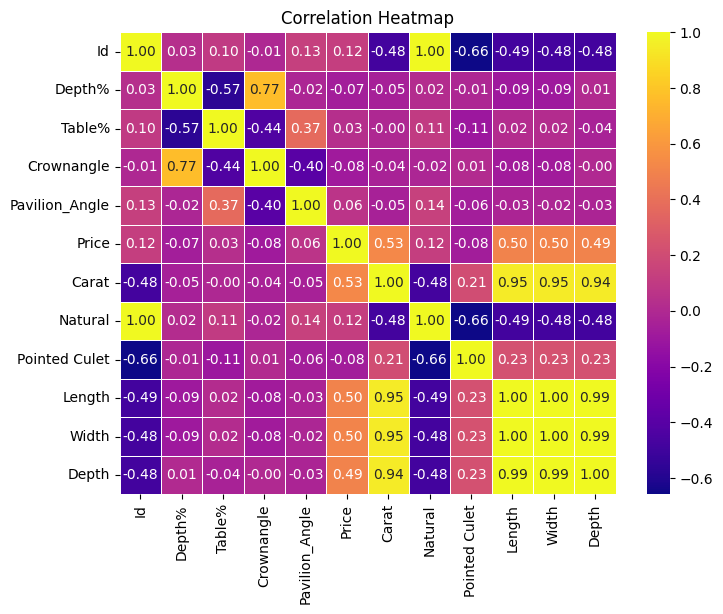

In [14]:
# Correlation heatmap
num_col = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(8, 6))
sns.heatmap(num_col.corr(), annot=True, cmap='plasma', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

- There is a high correlation between Carat and Length, Width, Depth because, of course, as the carat increases, the dimensions increase as well. We will prefer to use the dimensions ratio because it is a more respected measure in the diamond industry.

In [15]:
# Calculate L/W Ratio
df['L/W%'] = df['Length'] / df['Width']

#Diamond's depth is included in Depth% = also could indicates on its carat
# Drop old columns
df.drop(columns=['Length', 'Width', 'Depth'], inplace=True)

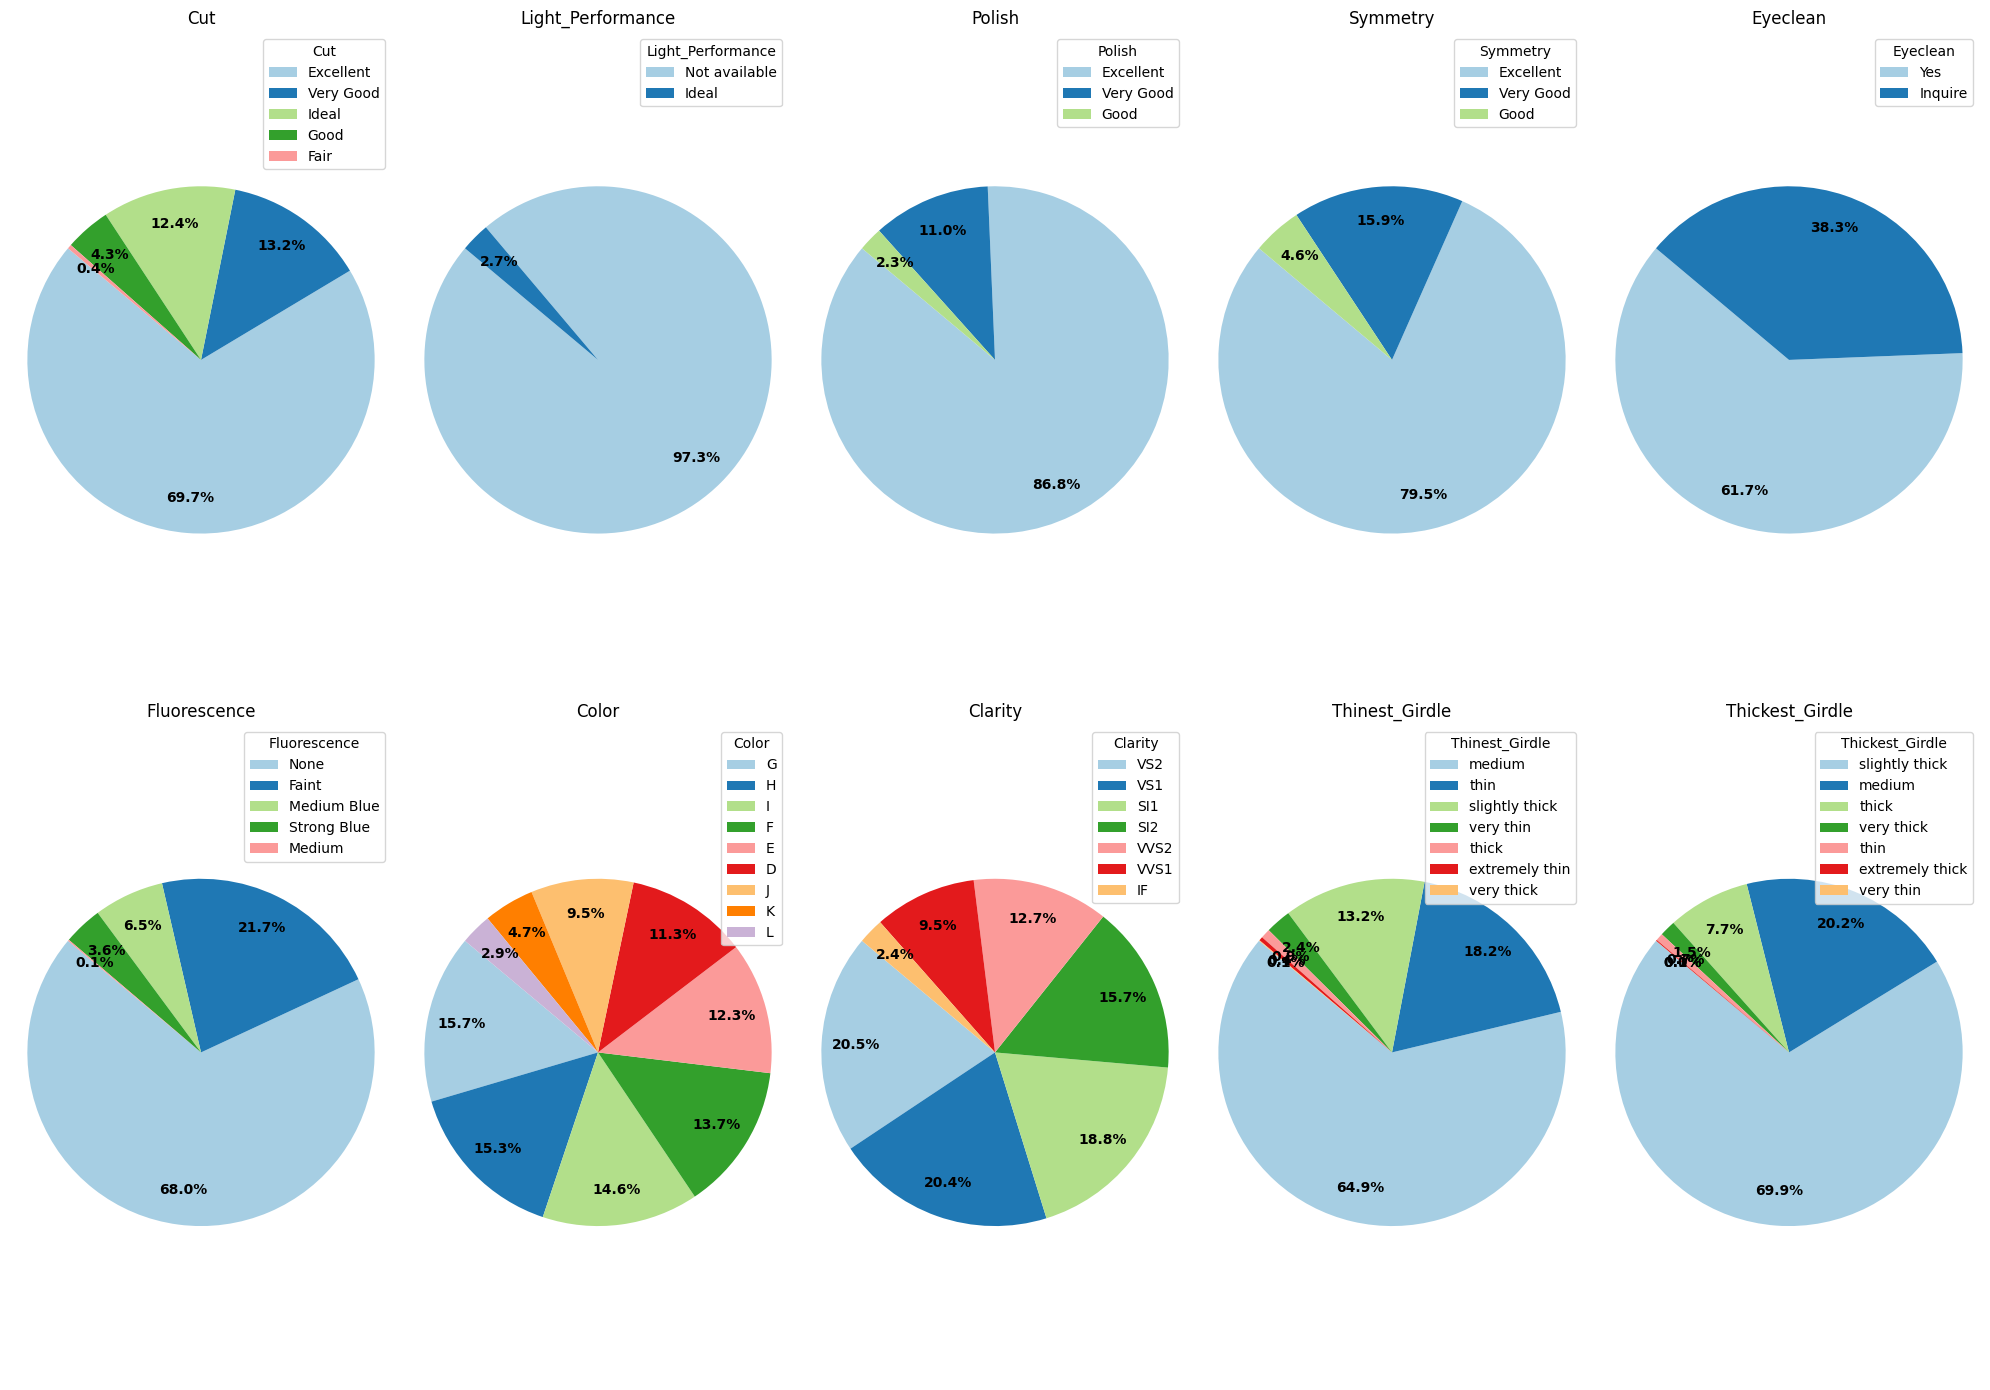

In [16]:
# Creating pie chart plots of categorical columns distribution
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 14))

cat_columns = ['Cut', 'Light_Performance', 'Polish', 'Symmetry', 'Eyeclean', 'Fluorescence', 'Color', 'Clarity', 'Thinest_Girdle', 'Thickest_Girdle']
for i, column in enumerate(cat_columns):
    frequencies = df[column].value_counts()
    row = i // 5
    col = i % 5
    
    # Choose color palette
    colors = Paired.colors[:len(frequencies)] 
    
    axes[row, col].pie(frequencies, labels=None, autopct=lambda p: f'{p:.1f}%'.format(p), startangle=140, pctdistance=0.8, textprops={'weight': 'bold'}, colors=colors)
    axes[row, col].set_title(f'{column}')
    axes[row, col].axis('equal')  
    axes[row, col].legend(labels=frequencies.index, title=column, loc='upper right') 

plt.tight_layout()
plt.show()

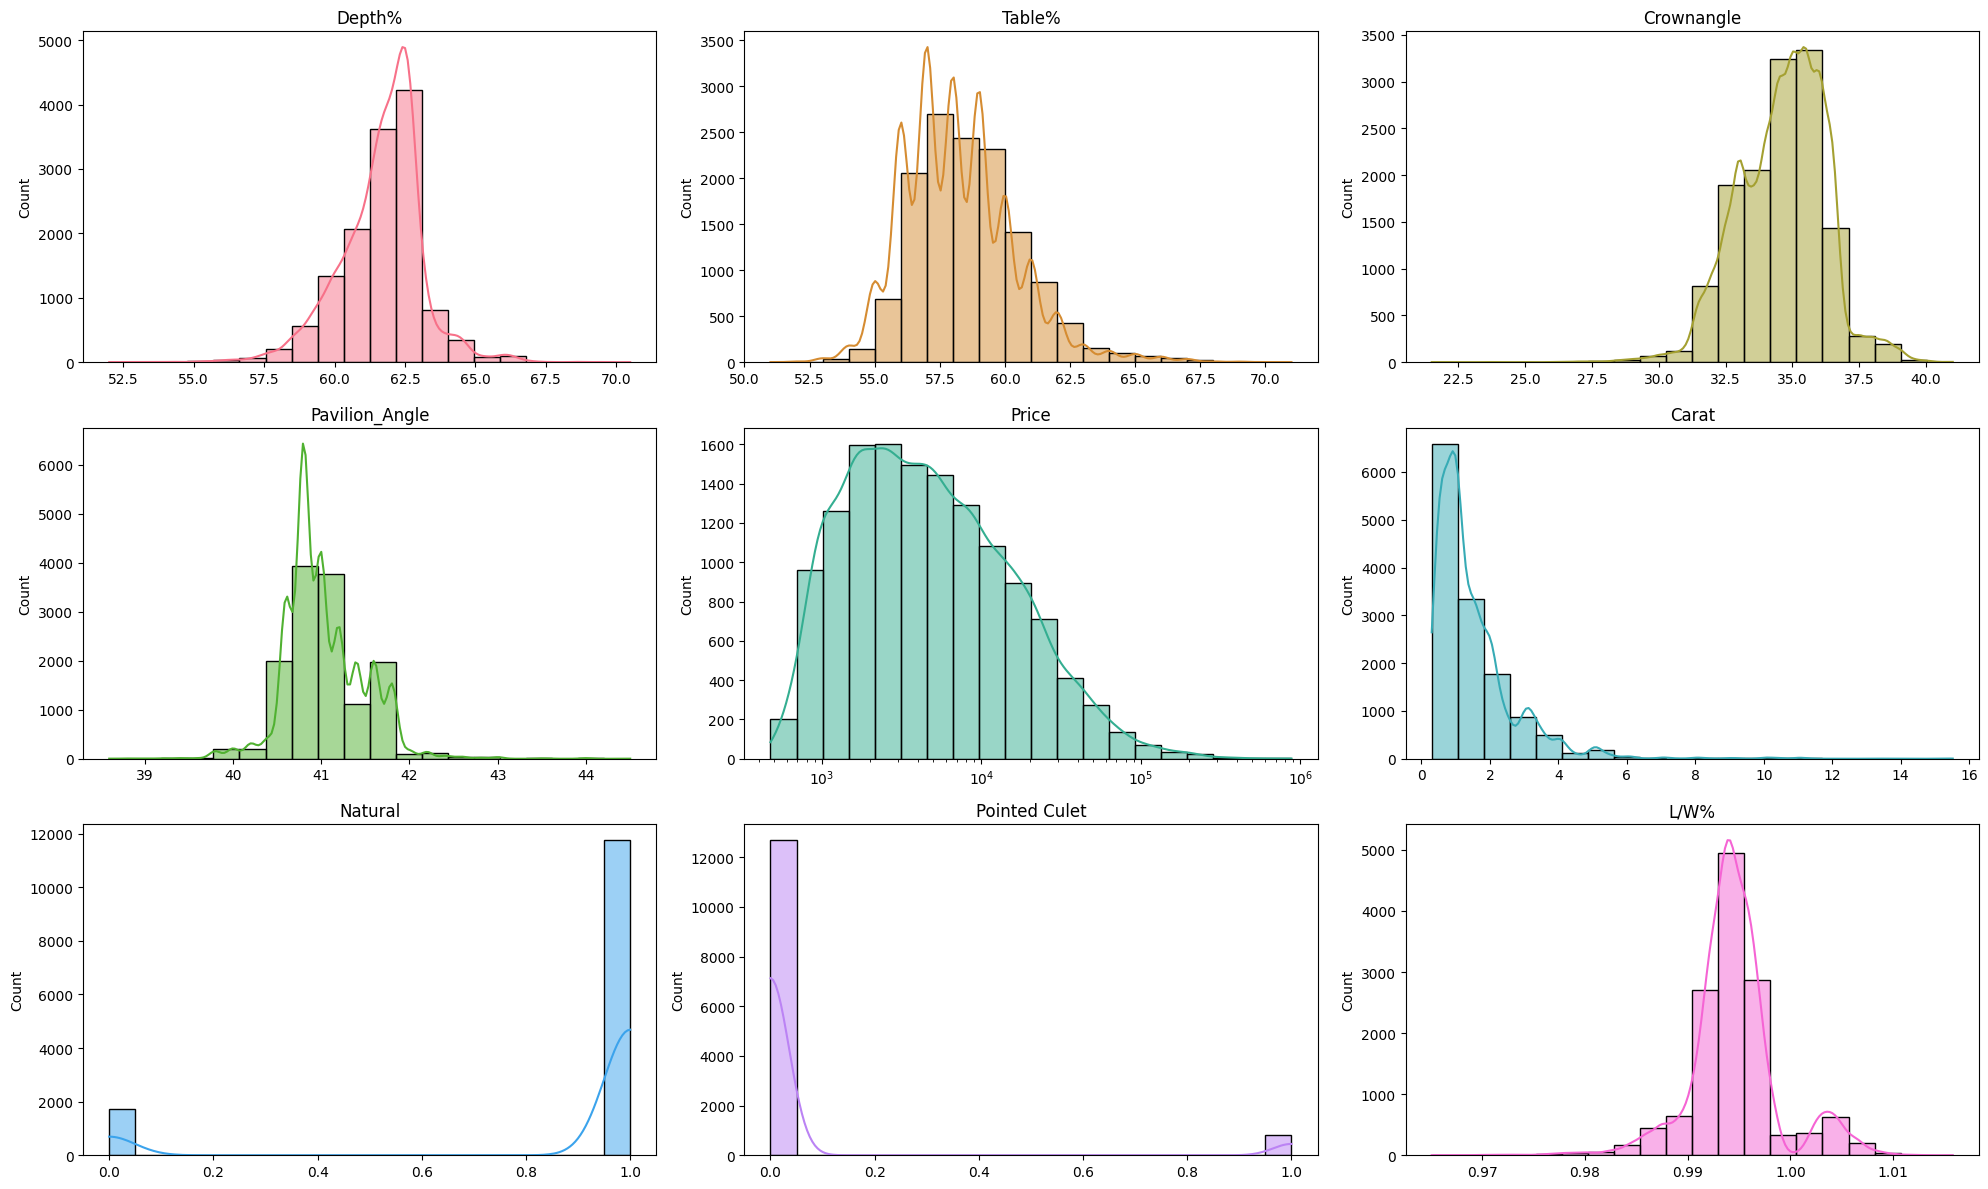

In [17]:
df_to_plot = df.drop(columns=['Id']).select_dtypes(include=np.number)
custom_palette = sns.color_palette("husl", n_colors=len(df_to_plot.columns))

plt.figure(figsize=(20, 12)) 
for i, column in enumerate(df_to_plot.columns):
    if column == "Price":
        plt.subplot(3, 3, i+1) 
        sns.histplot(df_to_plot[column], color=custom_palette[i], kde=True, bins=20, log_scale=True) #We need to log price
    else:
        plt.subplot(3, 3, i+1) 
        sns.histplot(df_to_plot[column], color=custom_palette[i], kde=True, bins=20)
    
    plt.title(column)
    plt.xlabel('')

# Adjust layout
plt.tight_layout()
plt.show()

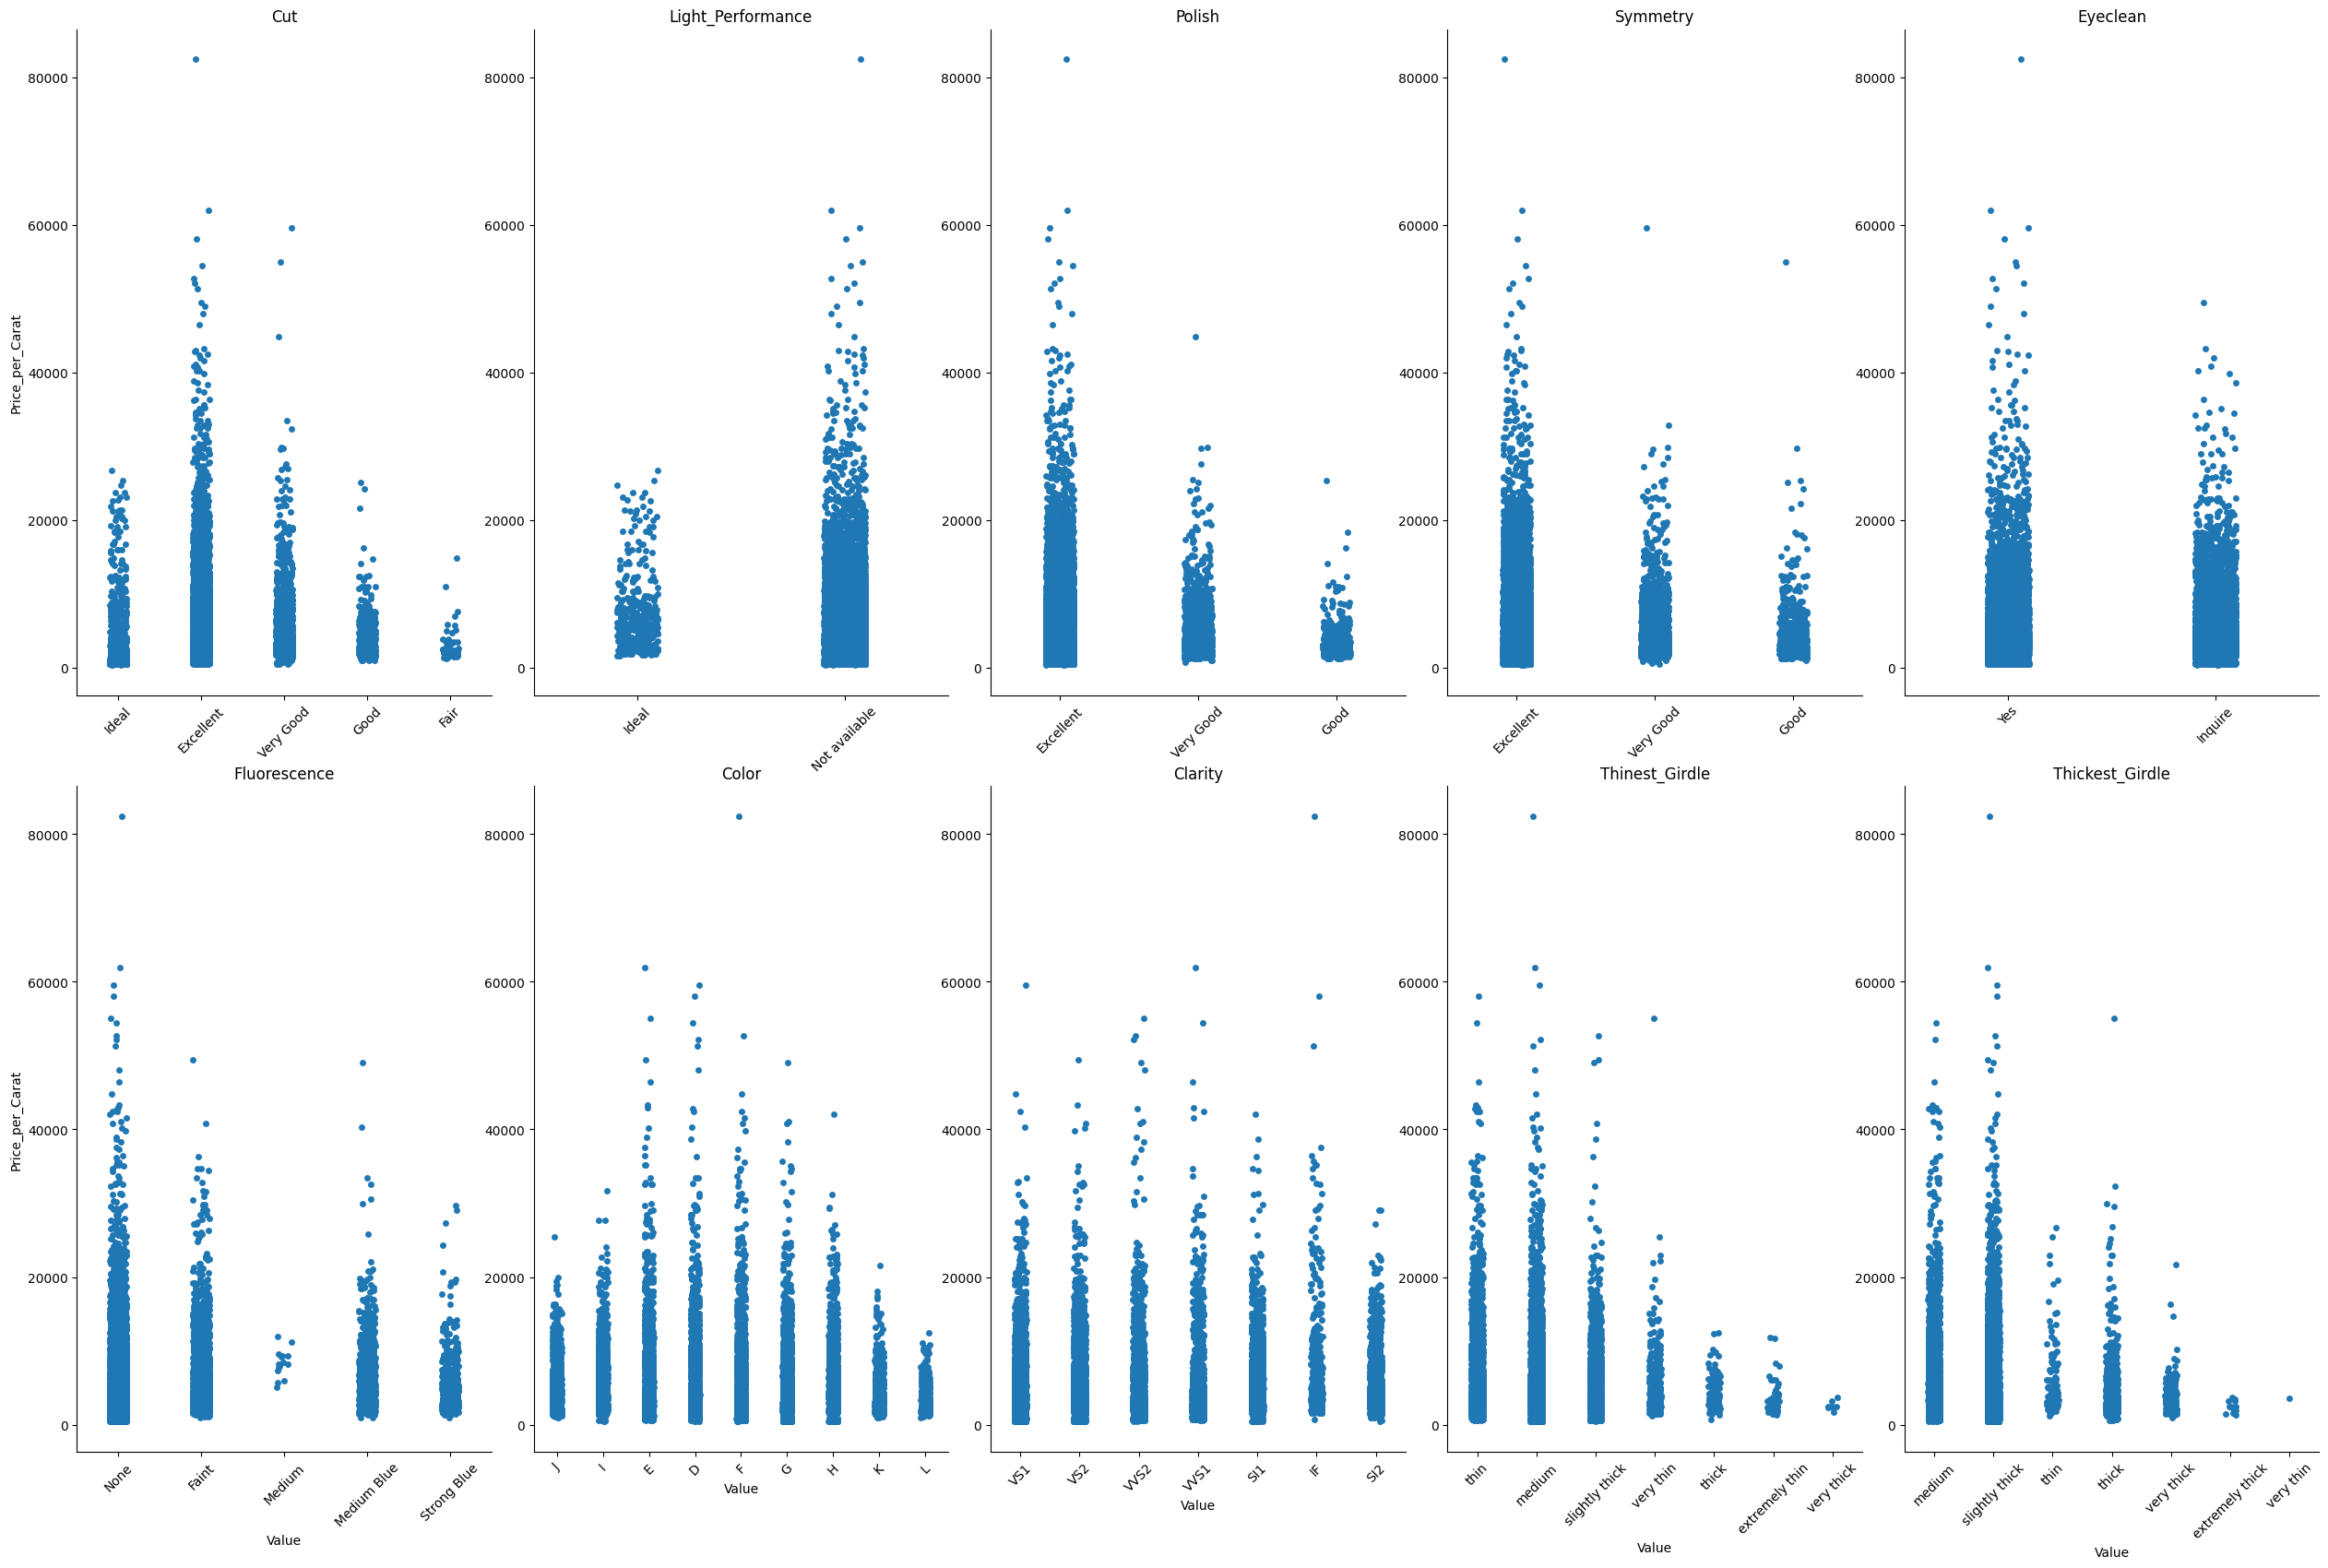

In [18]:
df['Price_per_Carat'] = df['Price'] / df['Carat']

# Reshape the DataFrame for catplot
df_catplot = df.melt(id_vars=['Price_per_Carat'], value_vars=cat_columns, var_name="Category", value_name="Value")

# Create a 2x5 grid of catplots
g = sns.catplot(
    data=df_catplot,
    kind="strip",  # Default kind is a strip plot
    x="Value",  # Use the new column 'Value' for the x-axis
    y="Price_per_Carat",
    col_wrap=5,  # Number of columns in each row
    col="Category",  # The column 'Category' to create subplots for
    aspect=1.5,  # Aspect ratio of each subplot
    sharey=False,  # Do not share y-axis across subplots
    sharex=False,  # Do not share x-axis across subplots
    height=5  # Height of each subplot
)

# Set title for each subplot
for i, ax in enumerate(g.axes.flat):
    ax.set_title(cat_columns[i])
    ax.set_xticks(ax.get_xticks())  # Set the tick positions explicitly
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Rotate x-axis labels

# Set the overall figure size
plt.gcf().set_size_inches(25, 17)

plt.show()

>> ### **Natural VS Lab Diamonds**

- Lab-grown diamonds are man-made diamonds that are chemically, physically, and optically identical to natural diamonds mined from the Earth. Natural diamonds are formed over billions of years through extreme heat and pressure deep within the Earth's mantle and brought closer to the surface through volcanic eruptions. While lab-grown diamonds are often more affordable due to their controlled manufacturing process, some prefer the rarity and perceived value of natural diamonds.

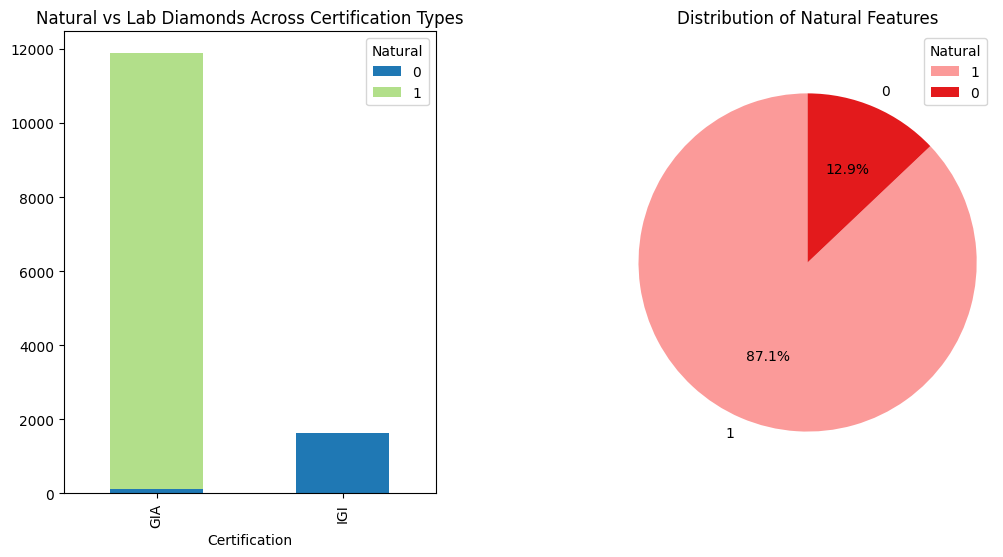

In [19]:
# Set up the subplots with adjusted spacing
fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'wspace': 0.5})

# Plot 1: Bar plot
counts = df.groupby(['Certification', 'Natural']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=True, ax=axs[0], color = colors[1:3])
axs[0].set_title('Natural vs Lab Diamonds Across Certification Types')

# Plot 2: Pie chart
pie = df['Natural'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[1], colors=colors[4:6])
axs[1].set_title('Distribution of Natural Features')
axs[1].set_ylabel('')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add legend with label "Natural"
axs[1].legend(df['Natural'].value_counts().index, title='Natural', loc='best')

# Manually adjust spacing
plt.subplots_adjust(wspace=0.5)

plt.show()

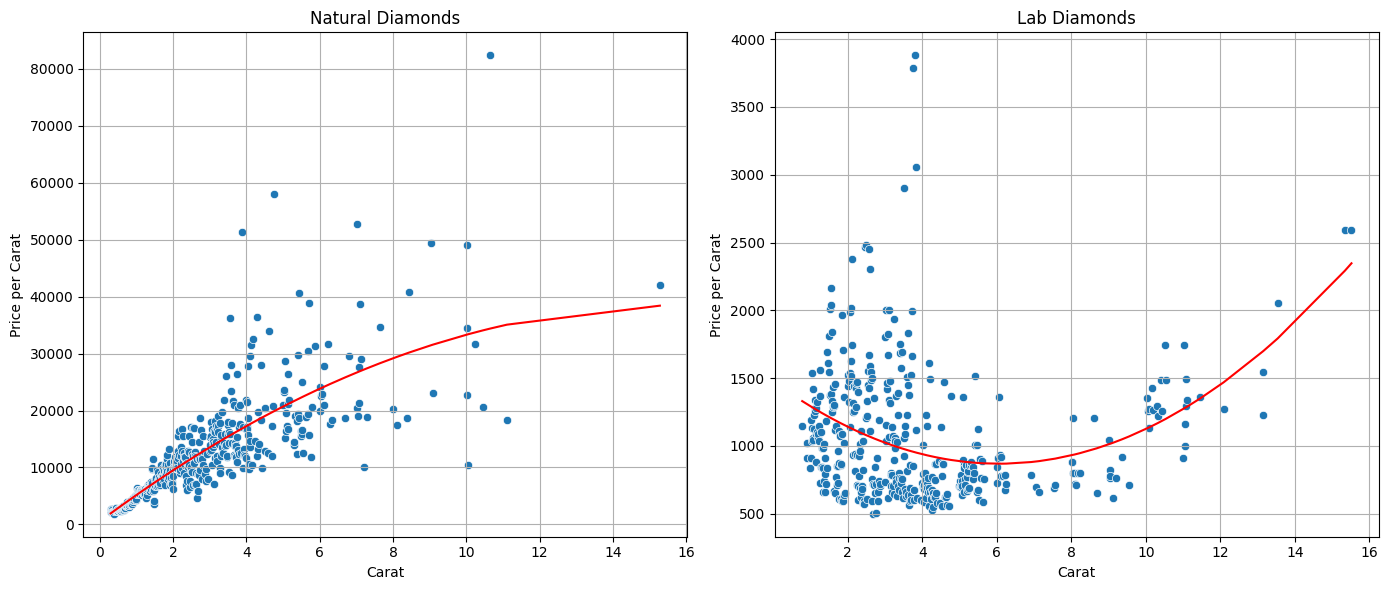

Polynomial Function (Natural == 1):
        2
-151.4 x + 4795 x + 496.5

Polynomial Function (Natural == 0):
       2
16.53 x - 200.5 x + 1477


In [20]:
# Your code to round 'Carat' column to the next 0.1 and calculate average price by rounded carat
df['Price_per_Carat'] = df['Price'] / df['Carat']

# Filtering for Natural diamonds where Natural == 1
df_natural_1 = df[df['Natural'] == 1]

# Group by 'rounded_carat' and calculate the average price
average_price_by_rounded_carat_1 = df_natural_1.groupby('Carat')['Price_per_Carat'].mean().reset_index()

# Fit a polynomial of degree 2 (quadratic) to the data
degree = 2
coefficients = np.polyfit(average_price_by_rounded_carat_1['Carat'], average_price_by_rounded_carat_1['Price_per_Carat'], degree)

# Create a polynomial function using the coefficients
poly_function = np.poly1d(coefficients)

# Plotting for Natural == 1
plt.figure(figsize=(14, 6))  # Adjusted figsize to accommodate two plots side by side

plt.subplot(1, 2, 1)  # Subplot for Natural == 1
sns.scatterplot(data=average_price_by_rounded_carat_1, x='Carat', y='Price_per_Carat', label='_nolegend_')
sns.lineplot(x=average_price_by_rounded_carat_1['Carat'], y=poly_function(average_price_by_rounded_carat_1['Carat']), color='red', label='_nolegend_')
plt.title('Natural Diamonds')
plt.ylabel('Price per Carat')
plt.grid(True)

# Filtering for Natural diamonds where Natural == 0
df_natural_0 = df[df['Natural'] == 0]

# Group by 'rounded_carat' and calculate the average price
average_price_by_rounded_carat_0 = df_natural_0.groupby('Carat')['Price_per_Carat'].mean().reset_index()

# Fit a polynomial of degree 2 (quadratic) to the data
coefficients_0 = np.polyfit(average_price_by_rounded_carat_0['Carat'], average_price_by_rounded_carat_0['Price_per_Carat'], degree)

# Create a polynomial function using the coefficients
poly_function_0 = np.poly1d(coefficients_0)

# Plotting for Natural == 0
plt.subplot(1, 2, 2)  # Subplot for Natural == 0
sns.scatterplot(data=average_price_by_rounded_carat_0, x='Carat', y='Price_per_Carat', label='_nolegend_')
sns.lineplot(x=average_price_by_rounded_carat_0['Carat'], y=poly_function_0(average_price_by_rounded_carat_0['Carat']), color='red', label='_nolegend_')
plt.title('Lab Diamonds')
plt.ylabel('Price per Carat')
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Print the polynomial functions
print("Polynomial Function (Natural == 1):")
print(poly_function)

print("\nPolynomial Function (Natural == 0):")
print(poly_function_0)

- As we can see here, the prices of lab-grown and natural diamonds do not behave in the same way. Since large diamonds are rare in nature, the larger the diamond, the higher its price per carat. With lab-grown diamonds, which are mainly produced for jewelry, we can see that the price is influenced by demand, meaning people prefer to buy smaller diamonds, mainly to set in jewelry, so the starting price is relatively high. In contrast, there is a decrease as the diamond gets larger, while for sizes that are not routine (over 8 carats), which are hardly produced as lab-grown diamonds, the prices increase accordingly.

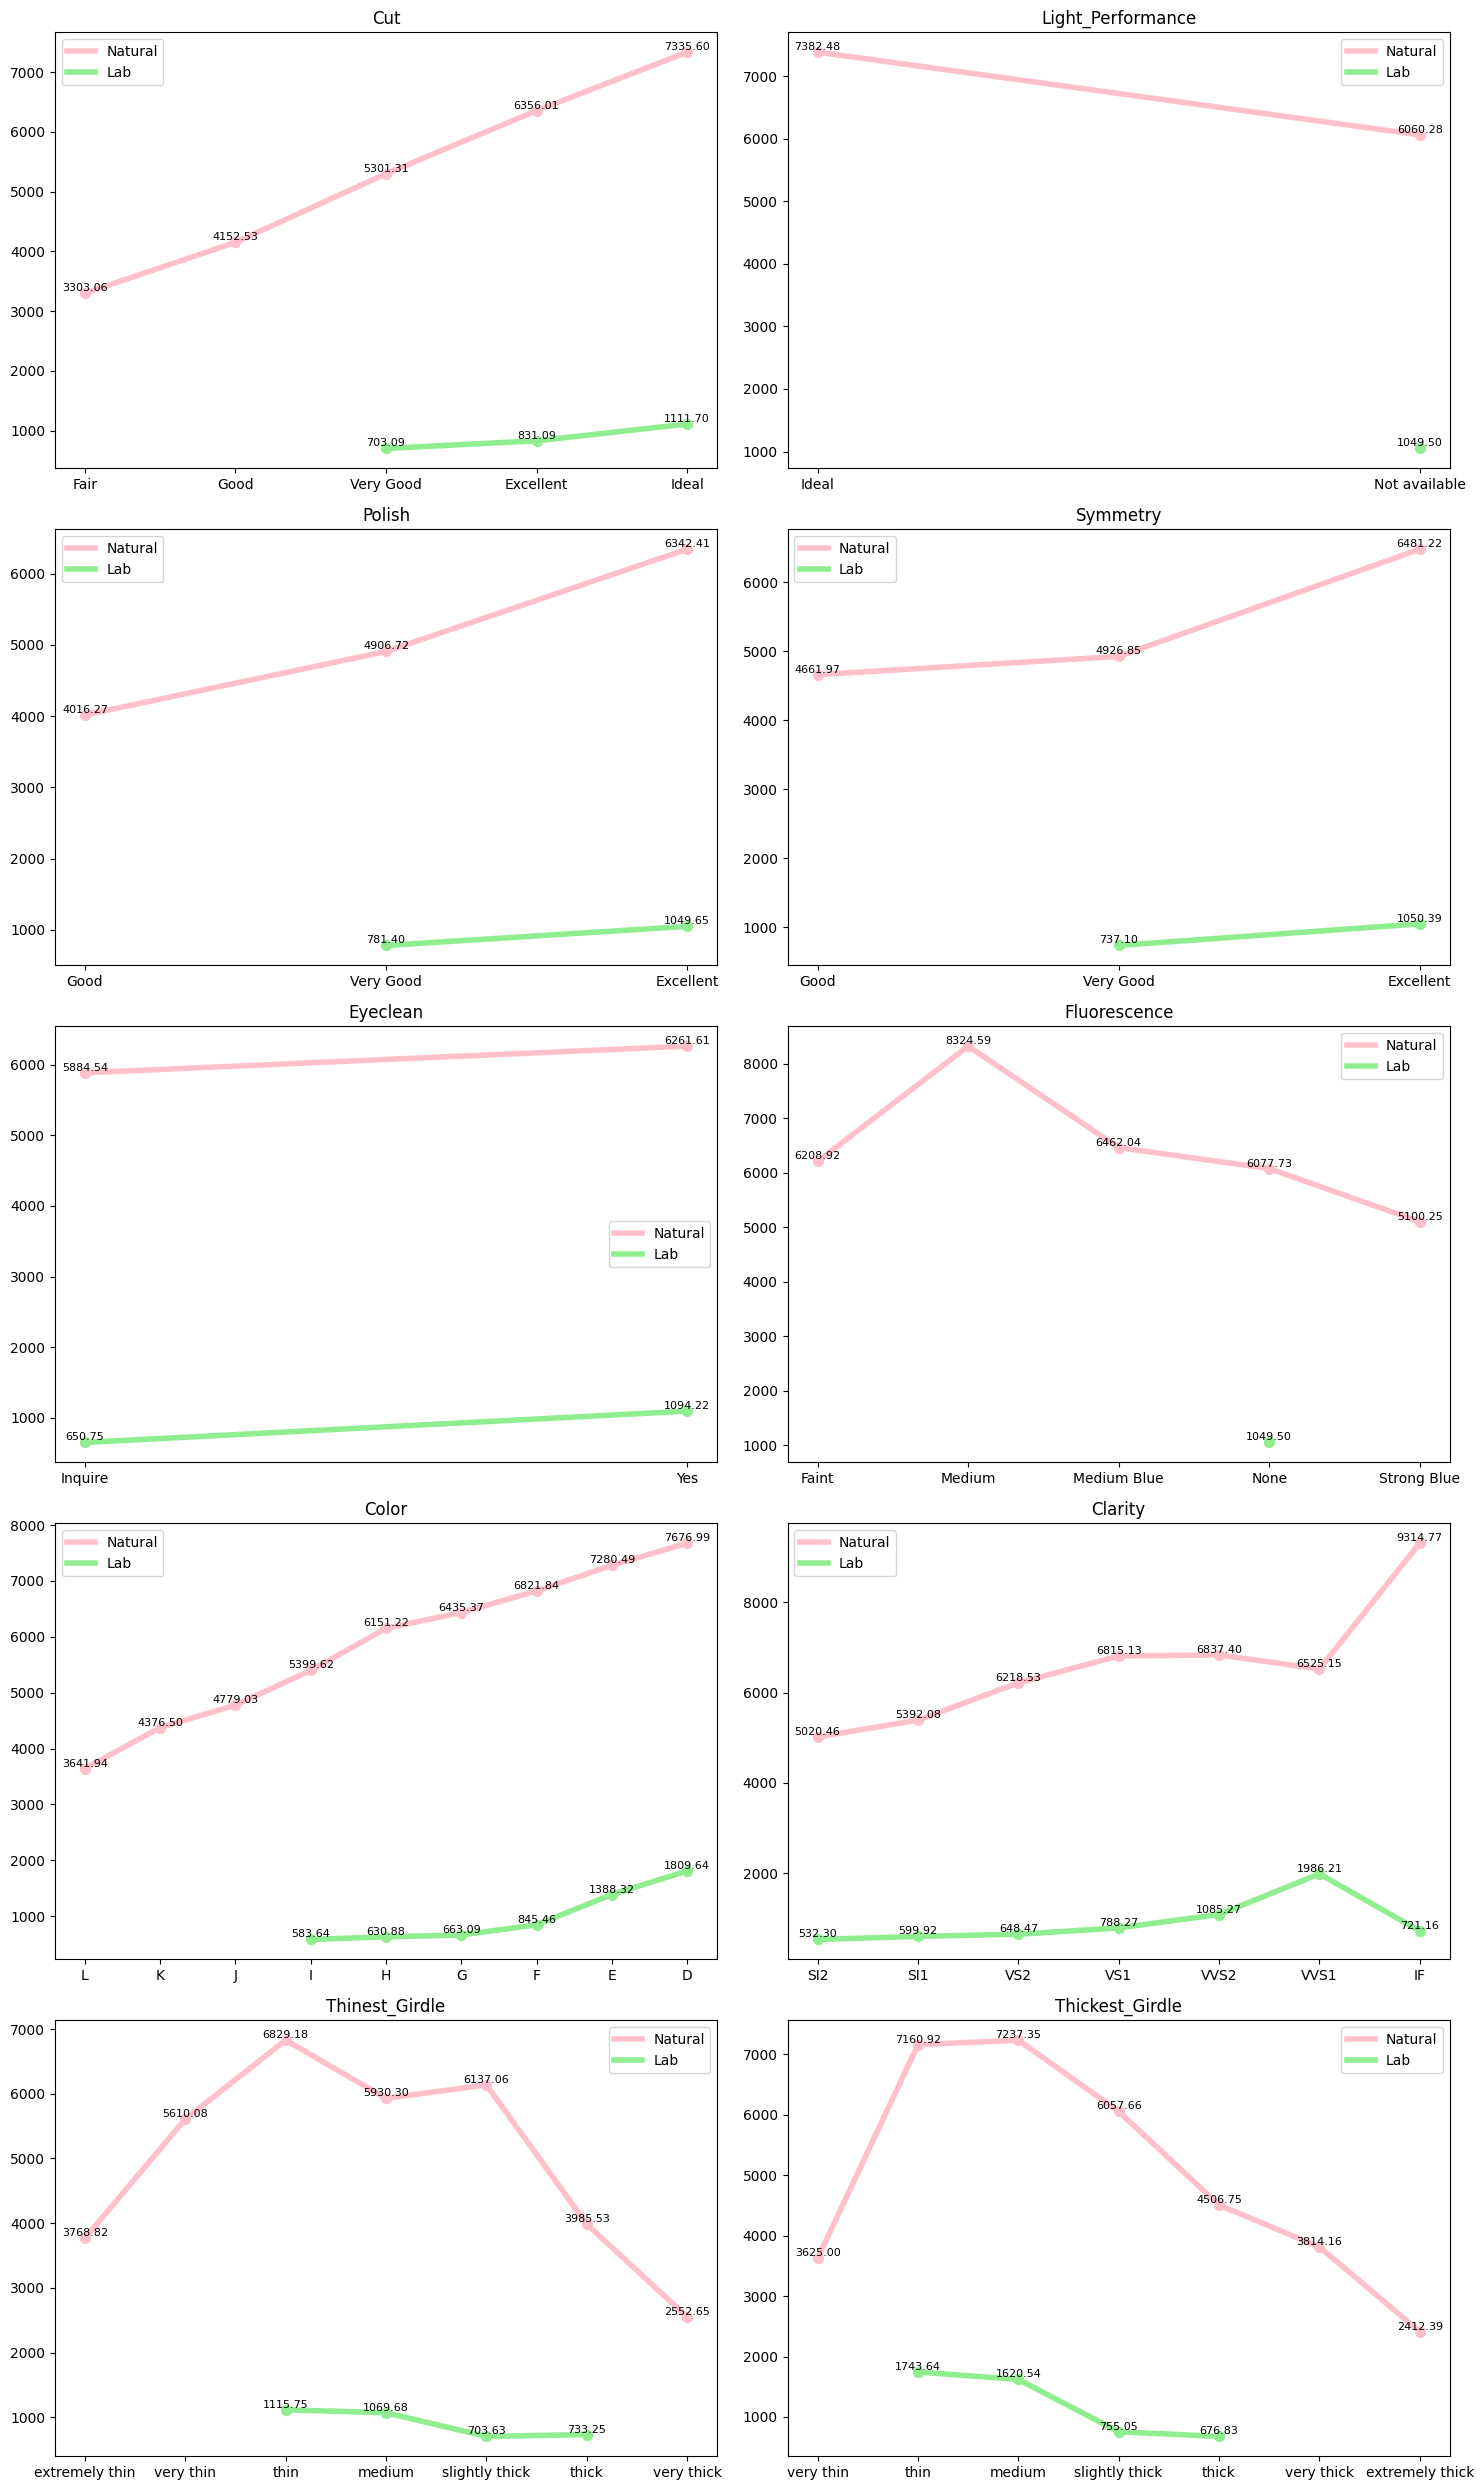

In [21]:
# Define the order of categories for each categorical column
column_order = {
    'Cut': ['Fair', 'Good', 'Very Good', 'Excellent', 'Ideal'],
    'Polish': ['Good', 'Very Good', 'Excellent'],
    'Symmetry': ['Good', 'Very Good', 'Excellent'],
    'Color': ['L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D'],
    'Clarity': ['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],
    'Thinest_Girdle': ['extremely thin', 'very thin', 'thin', 'medium', 'slightly thick', 'thick', 'very thick', 'extremely thick'],
    'Thickest_Girdle': ['extremely thin', 'very thin', 'thin', 'medium', 'slightly thick', 'thick', 'very thick', 'extremely thick']
}
# Set up the plot layout
num_columns = len(cat_columns)
num_rows = (num_columns + 1) // 2  # Arrange plots in 2 columns
plt.figure(figsize=(15, 5 * num_rows))

# Iterate over each categorical column
for i, cat_column in enumerate(cat_columns, start=1):
    plt.subplot(num_rows, 2, i)  # Set the subplot for current iteration
    
    # Compute the mean value for each category in the column for natural diamonds
    mean_values_natural = df[df['Natural'] == 1].groupby(cat_column)['Price_per_Carat'].mean()
    # Sort the mean values using custom sort order
    mean_values_natural = mean_values_natural.reindex(column_order.get(cat_column, sorted(df[cat_column].unique())))
    plt.plot(mean_values_natural, label='Natural', color='pink', linewidth=4)  # Set the line width to 2
    
    # Compute the mean value for each category in the column for lab diamonds
    mean_values_lab = df[df['Natural'] == 0].groupby(cat_column)['Price_per_Carat'].mean()
    # Sort the mean values using custom sort order
    mean_values_lab = mean_values_lab.reindex(column_order.get(cat_column, sorted(df[cat_column].unique())))
    plt.plot(mean_values_lab, label='Lab', color='lightgreen', linewidth=4)  # Set the line width to 2
    
    # Add points at each category with the color of the line (lab or natural)
    for category, mean_value in mean_values_natural.items():
        if np.isfinite(mean_value):
            plt.scatter(category, mean_value, color='pink', s=50, zorder=3)  # Set the size of the points
    for category, mean_value in mean_values_lab.items():
        if np.isfinite(mean_value):
            plt.scatter(category, mean_value, color='lightgreen', s=50, zorder=3)  # Set the size of the points
    
    # Add annotations for mean average values
    for category, mean_value in mean_values_natural.items():
        if np.isfinite(mean_value):
            plt.text(category, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', fontsize=8, color='black')
    for category, mean_value in mean_values_lab.items():
        if np.isfinite(mean_value):
            plt.text(category, mean_value, f'{mean_value:.2f}', ha='center', va='bottom', fontsize=8, color='black')
    
    plt.title(cat_column)
    plt.legend()
    
plt.tight_layout()
plt.show()


In [22]:
df.reset_index(inplace=True, drop=True)

In [23]:
df

Id    Cut        Itemcode   
0      4556847  Ideal  GIA-6224629781  \
1      4556848  Ideal  GIA-7442819108   
2      4556849  Ideal  GIA-1443371178   
3      4587786  Ideal  GIA-5222874985   
4      4590529  Ideal  GIA-1407253185   
...        ...    ...             ...   
13498   326374  Ideal  IGILG618472968   
13499   331672  Ideal  IGILG620460071   
13500   328940  Ideal  IGILG607315284   
13501   328939  Ideal  IGILG607315289   
13502   323389  Ideal  IGILG607315282   

                                                    Link Light_Performance   
0      /loose-diamonds/2.13-carat-j-color-vs1-clarity...             Ideal  \
1      /loose-diamonds/2.03-carat-j-color-vs1-clarity...             Ideal   
2      /loose-diamonds/1.64-carat-j-color-vs2-clarity...             Ideal   
3      /loose-diamonds/3.32-carat-i-color-vs2-clarity...             Ideal   
4      /loose-diamonds/1.07-carat-e-color-vs1-clarity...             Ideal   
...                                                  ...               ...   
13498  /loose-diamonds/13.14-carat-g-color-vvs2-clari...     Not available   
13499  /loose-diamonds/13.15-carat-g-color-vs1-clarit...     Not available   
13500  /loose-diamonds/13.54-carat-f-color-vs2-clarit...     Not available   
13501  /loose-diamonds/15.34-carat-g-color-vs1-clarit...     Not available   
13502  /loose-diamonds/15.52-carat-g-color-vs1-clarit...     Not available   

          Polish   Symmetry  Depth%  Table%  Crownangle  ...  Color Clarity   
0      Excellent  Excellent    60.9    56.0        35.0  ...      J     VS1  \
1      Excellent  Excellent    61.6    56.0        35.0  ...      J     VS1   
2      Excellent  Excellent    60.8    57.0        34.5  ...      J     VS2   
3      Excellent  Excellent    61.9    57.0        35.0  ...      I     VS2   
4      Excellent  Excellent    61.5    56.0        34.5  ...      E     VS1   
...          ...        ...     ...     ...         ...  ...    ...     ...   
13498  Excellent  Excellent    60.9    59.0        33.6  ...      G    VVS2   
13499  Excellent  Excellent    60.2    59.0        33.0  ...      G     VS1   
13500  Excellent  Excellent    61.4    58.0        34.8  ...      F     VS2   
13501  Excellent  Excellent    61.2    58.0        34.4  ...      G     VS1   
13502  Excellent  Excellent    61.1    58.0        34.5  ...      G     VS1   

       Carat  Natural Pointed Culet Fluorescence  Thinest_Girdle   
0       2.13        1             0         None            thin  \
1       2.03        1             0        Faint          medium   
2       1.64        1             0         None          medium   
3       3.32        1             0         None          medium   
4       1.07        1             0        Faint          medium   
...      ...      ...           ...          ...             ...   
13498  13.14        0             0         None          medium   
13499  13.15        0             0         None          medium   
13500  13.54        0             1         None          medium   
13501  15.34        0             1         None          medium   
13502  15.52        0             1         None          medium   

       Thickest_Girdle      L/W% Price_per_Carat  
0               medium  0.995221     9762.910798  
1               medium  0.992656     9729.064039  
2               medium  0.997382     7301.829268  
3       slightly thick  1.002099    15587.349398  
4               medium  0.996974     8773.831776  
...                ...       ...             ...  
13498   slightly thick  1.004630     1544.672755  
13499   slightly thick  1.004593     1228.973384  
13500           medium  0.996091     2053.028065  
13501           medium  0.994400     2595.501956  
13502           medium  0.996273     2595.489691  

[13503 rows x 24 columns]

----------------
># **Model Building**:

In [24]:
df.drop(columns=['Link','Light_Performance','Id','Itemcode', 'Price_per_Carat'],inplace=True)

In [25]:
# Define the numerical, ordinal, and categorical columns
num_cols = ['Depth%', 'Table%', 'Crownangle', 'Pavilion_Angle', 'Price', 'Carat', 'L/W%']
ordinal_cols = ['Cut', 'Polish', 'Symmetry', 'Color', 'Clarity', 'Thinest_Girdle', 'Thickest_Girdle']
cat_cols = ['Eyeclean', 'Certification', 'Pointed Culet', 'Natural', 'Fluorescence']

# Convert categorical columns to string type
df[cat_cols] = df[cat_cols].astype(str)

# Define preprocessing pipelines
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('ordinal_encoding', OrdinalEncoder(categories=[column_order[col] for col in ordinal_cols]))
])

categorical_pipeline = Pipeline([
    ('one_hot_encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
])

# Define ColumnTransformer
column_transformer = ColumnTransformer([
    ('numerical_preprocessing', numerical_pipeline, num_cols),
    ('ordinal_preprocessing', ordinal_pipeline, ordinal_cols),
    ('categorical_preprocessing', categorical_pipeline, cat_cols)
], remainder='passthrough')

# Preprocessing the data with the pipeline
X_processed = column_transformer.fit_transform(df)
X_processed = pd.DataFrame(X_processed, columns= num_cols + ordinal_cols + list(column_transformer.named_transformers_['categorical_preprocessing'].named_steps['one_hot_encoding'].get_feature_names_out(cat_cols)))

------------------------------
> # **PCA**

>> ## **Selecting the number of PCA components**

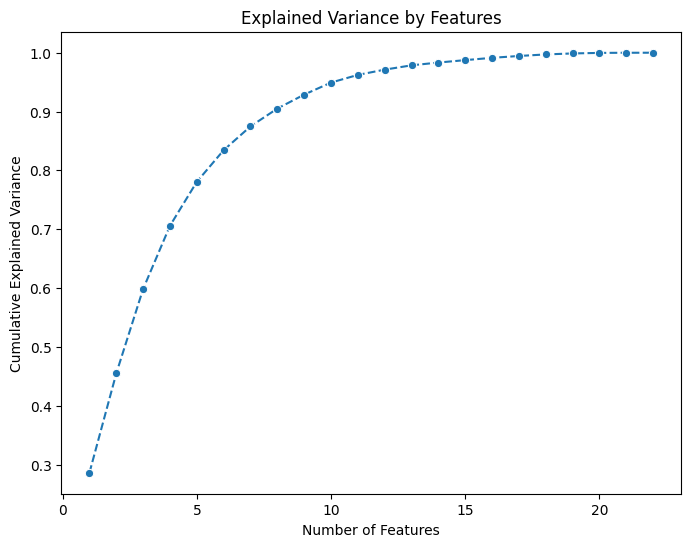

In [26]:
# Creating graph to know explained variance with different number of features of PCA
pca = PCA()
pca.fit(X_processed)

cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, len(cumulative_variance) + 1), y=cumulative_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [27]:
pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_processed)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

print('Cumulative variance explained by {} principal components: {:.2%}'.format(len(pca.explained_variance_ratio_), np.sum(pca.explained_variance_ratio_)))
 
# Convert it to a Pandas DataFrame
X_processed_df = pd.DataFrame(X_processed, columns=['Feature_{}'.format(i) for i in range(X_processed.shape[1])])

Explained variation per principal component: [0.28610596 0.16888094 0.14348156 0.10740573]
Cumulative variance explained by 4 principal components: 70.59%


In [28]:
# Create DataFrame for PCA components
dataset_pca = pd.DataFrame(abs(pca.components_), columns=X_processed.columns, index=['PC_1', 'PC_2','PC_3','PC_4'])
dataset_pca

Depth%    Table%  Crownangle  Pavilion_Angle     Price     Carat   
PC_1  0.073199  0.017074    0.058864        0.021106  0.011726  0.013006  \
PC_2  0.173751  0.080661    0.161114        0.076572  0.022714  0.071833   
PC_3  0.488013  0.505658    0.510628        0.323590  0.076921  0.029643   
PC_4  0.164829  0.074648    0.139201        0.109393  0.402982  0.594246   

          L/W%       Cut    Polish  Symmetry  ...  Thinest_Girdle   
PC_1  0.097902  0.069976  0.007846  0.016257  ...        0.024898  \
PC_2  0.128581  0.099958  0.023607  0.044710  ...        0.040559   
PC_3  0.167028  0.120368  0.085292  0.101620  ...        0.134378   
PC_4  0.452624  0.266692  0.107056  0.183340  ...        0.029050   

      Thickest_Girdle  Eyeclean_Yes  Certification_IGI  Pointed Culet_1   
PC_1         0.055480      0.064901           0.048023         0.031161  \
PC_2         0.104588      0.208148           0.047345         0.026182   
PC_3         0.060553      0.046338           0.050744         0.022779   
PC_4         0.115405      0.081450           0.087970         0.017598   

      Natural_1  Fluorescence_Medium  Fluorescence_Medium Blue   
PC_1   0.052148             0.000530                  0.009805  \
PC_2   0.049842             0.000284                  0.010329   
PC_3   0.052582             0.000465                  0.003783   
PC_4   0.096607             0.000419                  0.003032   

      Fluorescence_None  Fluorescence_Strong Blue  
PC_1           0.024714                  0.003175  
PC_2           0.034388                  0.006896  
PC_3           0.020968                  0.001563  
PC_4           0.029626                  0.009102  

[4 rows x 22 columns]

In [29]:
important_features = {}

print('Most important features for each component:')
for pc_number, pc_features in dataset_pca[dataset_pca > 0.4].iterrows():
    pc_dict = {}
    features = pc_features.dropna()
    if not features.empty:
        for feature, value in features.items():
            pc_dict[feature] = value
    else:
        pc_dict["No features above 0.4"] = None
    important_features[f'{pc_number}'] = pc_dict

for pc, features in important_features.items():
    print(f"{pc}: {features}\n")

Most important features for each component:
PC_1: {'Color': 0.9519225184488874}

PC_2: {'Clarity': 0.8679104793102247}

PC_3: {'Depth%': 0.48801323694544996, 'Table%': 0.5056578693171188, 'Crownangle': 0.5106284159622112}

PC_4: {'Price': 0.40298188442635563, 'Carat': 0.5942456356184926, 'L/W%': 0.4526240404416212}



- In the research hypothesis, we wanted to examine whether the 4Cs are indeed significant factors in the division of diamonds into clusters. As can be seen, color, clarity, and carat are significant features in every component of the PCA. We expected that cut would also be a significant component. After further examination, we saw that the GIA grades the cut using several measures: how the diamond looks,durability (we don't have this information) proportions, polish, and symmetry.

- After searching on the internet, we found that Depth%, Table%, Crown angle, and L/W%, important features for the PCA components are features that influence proportions, durability, and the appearance of the diamond. We will try to check if these parameters can predict the cut score and understand their relationship to the cut score. We will use the RandomForestClassifier() to investigate this claim.


>>## **Checking if Depth%, Table%, CrownAngel, and L/W can predict the Cut score**

In [30]:
features = ['Depth%', 'Table%', 'Crownangle', 'L/W%']
target = 'Cut'

X = X_processed[features]
y = X_processed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()

#Train the Model
model.fit(X_train, y_train)

#Evaluate the Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

#Feature Importance
feature_importance = pd.DataFrame(model.feature_importances_, index=features, columns=['Importance'])
print(feature_importance)


              precision    recall  f1-score   support

         0.0       1.00      0.21      0.35        14
         1.0       0.78      0.51      0.62       123
         2.0       0.73      0.60      0.66       372
         3.0       0.90      0.97      0.93      1841
         4.0       0.92      0.85      0.88       351

    accuracy                           0.88      2701
   macro avg       0.86      0.63      0.69      2701
weighted avg       0.87      0.88      0.87      2701

            Importance
Depth%        0.235359
Table%        0.151650
Crownangle    0.233278
L/W%          0.379713


- It seems that the model predicts the two higher levels of cut quite accurately, which are the most common based on these parameters. This suggests that these parameters are significant in determining the cut score.

--------------
># **Choosing Model**

Elbow Method to determine the number of clusters to be formed:


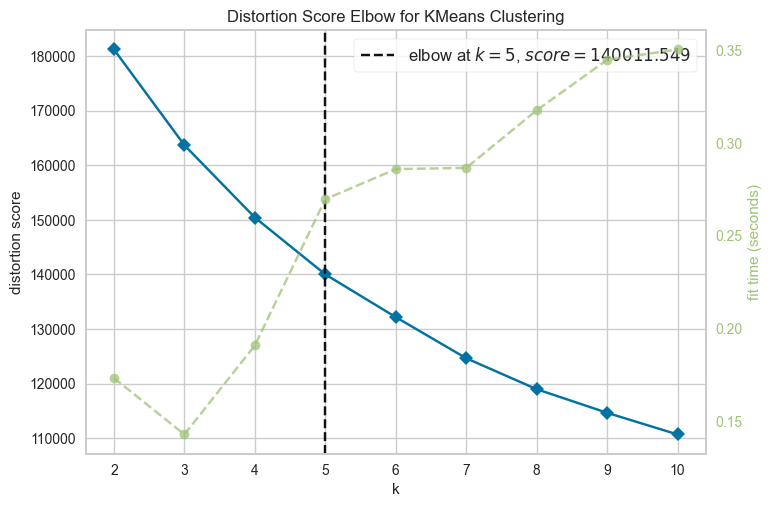

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
from yellowbrick.cluster import KElbowVisualizer
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_Model = KElbowVisualizer(KMeans(n_init=10), k=10)
Elbow_Model.fit(X_processed)
Elbow_Model.show()

In [32]:
n_clusters = 5 #according to the graph

In [33]:
dataset_pca

Depth%    Table%  Crownangle  Pavilion_Angle     Price     Carat   
PC_1  0.073199  0.017074    0.058864        0.021106  0.011726  0.013006  \
PC_2  0.173751  0.080661    0.161114        0.076572  0.022714  0.071833   
PC_3  0.488013  0.505658    0.510628        0.323590  0.076921  0.029643   
PC_4  0.164829  0.074648    0.139201        0.109393  0.402982  0.594246   

          L/W%       Cut    Polish  Symmetry  ...  Thinest_Girdle   
PC_1  0.097902  0.069976  0.007846  0.016257  ...        0.024898  \
PC_2  0.128581  0.099958  0.023607  0.044710  ...        0.040559   
PC_3  0.167028  0.120368  0.085292  0.101620  ...        0.134378   
PC_4  0.452624  0.266692  0.107056  0.183340  ...        0.029050   

      Thickest_Girdle  Eyeclean_Yes  Certification_IGI  Pointed Culet_1   
PC_1         0.055480      0.064901           0.048023         0.031161  \
PC_2         0.104588      0.208148           0.047345         0.026182   
PC_3         0.060553      0.046338           0.050744         0.022779   
PC_4         0.115405      0.081450           0.087970         0.017598   

      Natural_1  Fluorescence_Medium  Fluorescence_Medium Blue   
PC_1   0.052148             0.000530                  0.009805  \
PC_2   0.049842             0.000284                  0.010329   
PC_3   0.052582             0.000465                  0.003783   
PC_4   0.096607             0.000419                  0.003032   

      Fluorescence_None  Fluorescence_Strong Blue  
PC_1           0.024714                  0.003175  
PC_2           0.034388                  0.006896  
PC_3           0.020968                  0.001563  
PC_4           0.029626                  0.009102  

[4 rows x 22 columns]

>> ## **KMeans model**

In [34]:
# Define and fit the KMeans clustering model
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(pca_result)

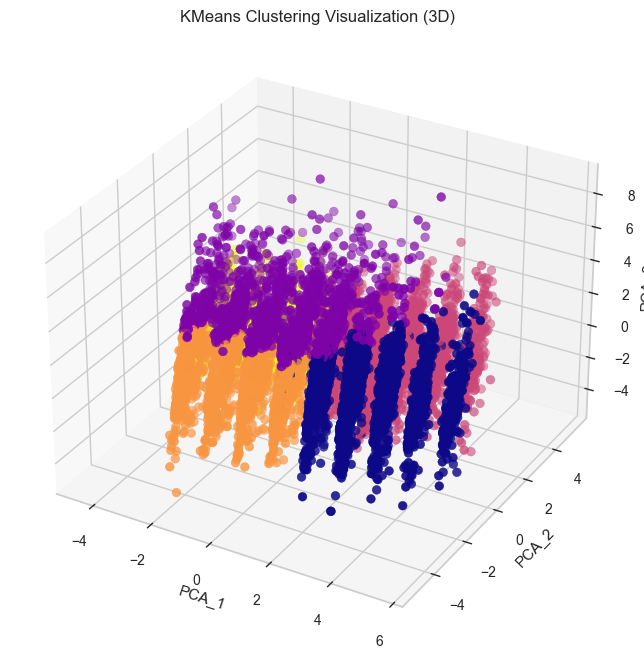

In [35]:
# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], s=40, c=kmeans_labels, marker='o', cmap='plasma')
ax.set_title("KMeans Clustering Visualization (3D)")

ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')
plt.show()

In [36]:
# Evaluate the model using silhouette score
silhouette_avg = silhouette_score(pca_result, kmeans_labels)

print("Silhouette Score for Kmeans Model:", silhouette_avg)

# Evaluate the model using squared error
# Calculate the centroids of each cluster
centroids = []
for cluster_label in np.unique(kmeans_labels):
    cluster_points = pca_result[kmeans_labels == cluster_label]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

# Calculate the squared distances of each point to its cluster centroid
squared_distances = []
for cluster_label in np.unique(kmeans_labels):
    cluster_points = pca_result[kmeans_labels == cluster_label]
    centroid = centroids[cluster_label]
    distances = np.sum((cluster_points - centroid) ** 2, axis=1)
    squared_distances.extend(distances)

# Calculate the total within-cluster sum of squared errors (SSE)
sse = np.sum(squared_distances)

print("Total Within-Cluster Sum of Squared Errors of Kmeans Model (SSE):", sse)

Silhouette Score for Kmeans Model: 0.23477221310648472
Total Within-Cluster Sum of Squared Errors of Kmeans Model (SSE): 74091.25863133298


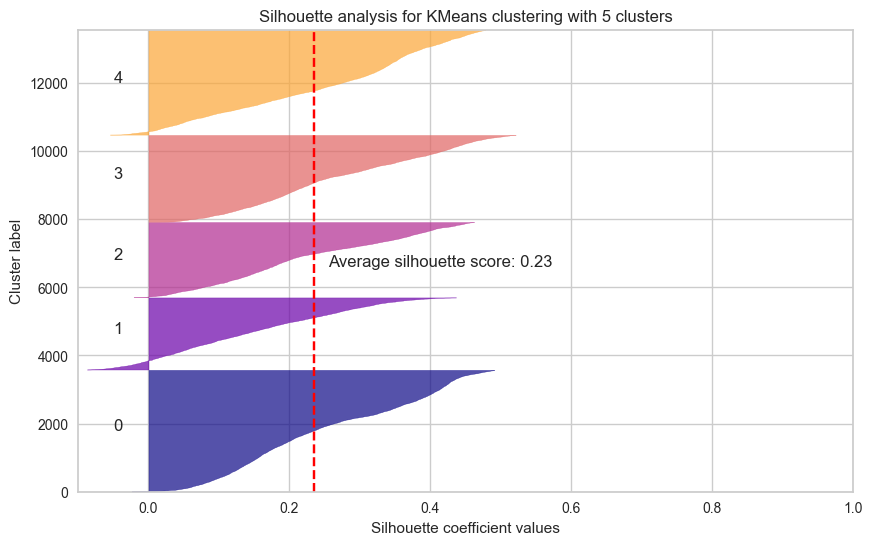

In [37]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(pca_result, kmeans_labels)

# Create a subplot with 1 row and 1 column
plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Set y-axis limits
ax1.set_ylim(0, len(pca_result) + (n_clusters + 1) * 10)

# Compute y-axis location for each cluster label
y_lower = 10
for i in range(n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
    cluster_silhouette_values.sort()
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill color for each cluster
    color = plt.cm.plasma(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label silhouette plots with cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute new y_lower for next plot
    y_lower = y_upper + 10

# Plot silhouette score line
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# Annotate silhouette score
ax1.text(silhouette_avg + 0.02, 0.5 * len(pca_result), 'Average silhouette score: {:.2f}'.format(silhouette_avg),
         verticalalignment='center')

# Set x-axis limits
ax1.set_xlim([-0.1, 1])
plt.title('Silhouette analysis for KMeans clustering with {} clusters'.format(n_clusters))
plt.show()

>> ### **Agglomerative Clustering**

In [38]:
for n_clusters in range(2, 9):  # Try different numbers of clusters
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative.fit_predict(X_processed)
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    print(f"For {n_clusters} clusters, the silhouette score is {silhouette_avg}")

For 2 clusters, the silhouette score is 0.15144683081509522
For 3 clusters, the silhouette score is 0.09715722769581621
For 4 clusters, the silhouette score is 0.08462867161206858
For 5 clusters, the silhouette score is 0.08619908895618217
For 6 clusters, the silhouette score is 0.09743241395786394
For 7 clusters, the silhouette score is 0.10487927152984043
For 8 clusters, the silhouette score is 0.0999992906684637


In [39]:
# Define and fit the KMeans clustering model
agg_model = AgglomerativeClustering(n_clusters=2)  # Define the number of clusters
agg_model.fit(pca_result)

# Get the cluster labels assigned to each sample
agg_labels = agg_model.labels_

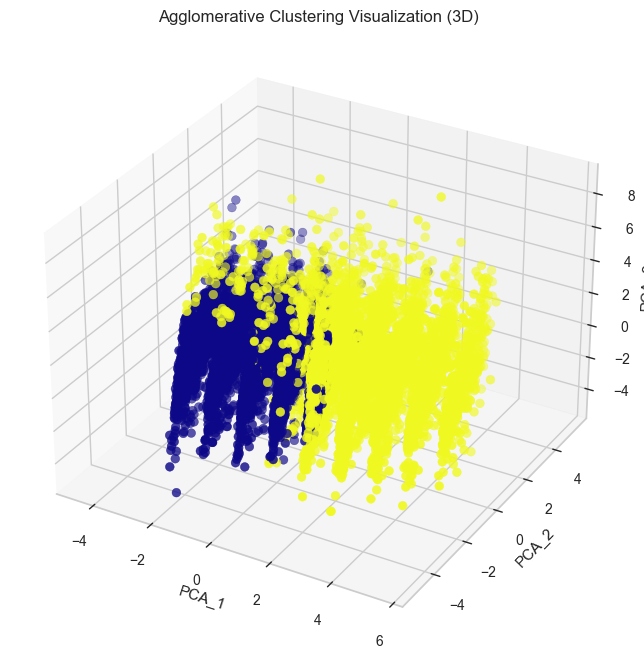

In [40]:
# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], s=40, c=agg_labels, marker='o', cmap='plasma')
ax.set_title("Agglomerative Clustering Visualization (3D)")

ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')
plt.show()

In [41]:
# Evaluate the model using silhouette score
silhouette_avg = silhouette_score(pca_result, agg_labels)

print("Silhouette Score for Agglomerative Model:", silhouette_avg)

# Evaluate the model using squared error
# Calculate the centroids of each cluster
centroids = []
for cluster_label in np.unique(agg_labels):
    cluster_points = pca_result[agg_labels == cluster_label]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

# Calculate the squared distances of each point to its cluster centroid
squared_distances = []
for cluster_label in np.unique(agg_labels):
    cluster_points = pca_result[agg_labels == cluster_label]
    centroid = centroids[cluster_label]
    distances = np.sum((cluster_points - centroid) ** 2, axis=1)
    squared_distances.extend(distances)

# Calculate the total within-cluster sum of squared errors (SSE)
sse = np.sum(squared_distances)

print("Total Within-Cluster Sum of Squared Errors of Agglomerative Model (SSE):", sse)

Silhouette Score for Agglomerative Model: 0.23327785068341847
Total Within-Cluster Sum of Squared Errors of Agglomerative Model (SSE): 120355.4464773487


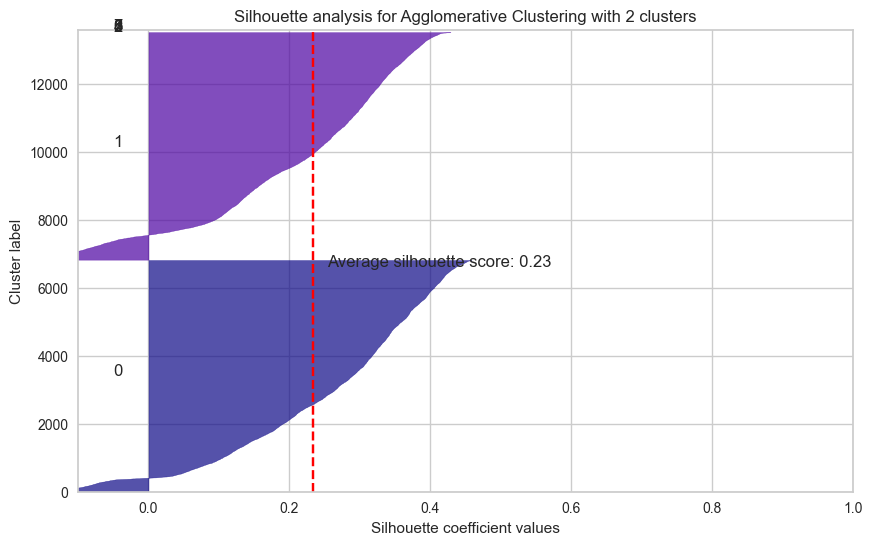

In [42]:
# Compute the silhouette scores for each sample
silhouette_avg = silhouette_score(pca_result, agg_labels)
sample_silhouette_values = silhouette_samples(pca_result, agg_labels)

# Create a subplot with 1 row and 1 column
plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Set y-axis limits
ax1.set_ylim(0, len(pca_result) + (n_clusters + 1) * 10)

# Compute y-axis location for each cluster label
y_lower = 10
for i in range(n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    cluster_silhouette_values = sample_silhouette_values[agg_labels == i]
    cluster_silhouette_values.sort()
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill color for each cluster
    color = plt.cm.plasma(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label silhouette plots with cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute new y_lower for next plot
    y_lower = y_upper + 10

# Plot silhouette score line
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# Annotate silhouette score
ax1.text(silhouette_avg + 0.02, 0.5 * len(pca_result), 'Average silhouette score: {:.2f}'.format(silhouette_avg),
         verticalalignment='center')

# Set x-axis limits
ax1.set_xlim([-0.1, 1])
plt.title('Silhouette analysis for Agglomerative Clustering with 2 clusters')
plt.show()

>> ### **DBSCAN Clustering**

In [43]:
def find_best_dbscan_params(data, eps_range, min_samples_range):
    best_score = -1
    best_params = {}
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            if len(np.unique(labels)) > 1:  # Silhouette score requires at least 2 clusters
                score = silhouette_score(data, labels)
                if score > best_score:
                    best_score = score
                    best_params['eps'] = eps
                    best_params['min_samples'] = min_samples
    return best_params


best_params = find_best_dbscan_params(pca_result, eps_range=[0.1, 0.5, 1.0, 1.1], min_samples_range=[3, 5, 8, 10])
print("Best DBSCAN parameters:", best_params)

# Using the best parameters to perform DBSCAN clustering
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
db_labels = dbscan.fit_predict(pca_result)

Best DBSCAN parameters: {'eps': 1.1, 'min_samples': 8}


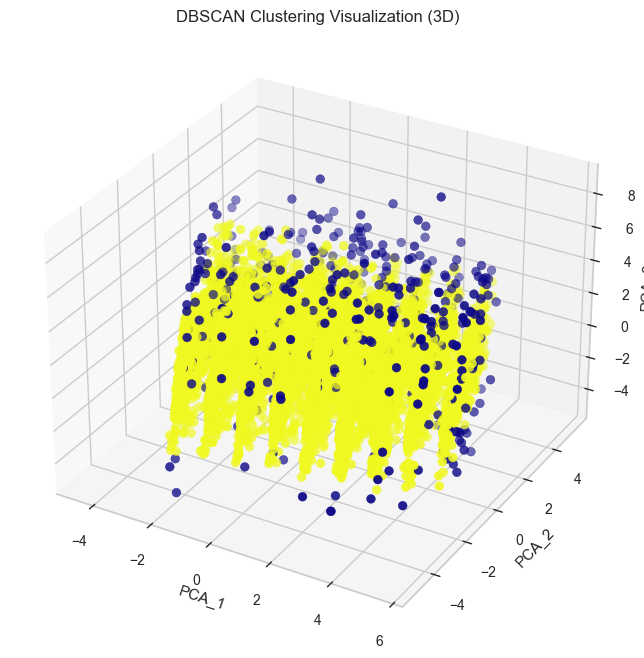

In [44]:
# Plotting the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', label="bla")
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], s=40, c=db_labels, marker='o', cmap='plasma')
ax.set_title("DBSCAN Clustering Visualization (3D)")

ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')
plt.show()

In [45]:
# Evaluate the model using silhouette score
silhouette_avg = silhouette_score(pca_result, db_labels)

print("Silhouette Score for DBSCAN Model:", silhouette_avg)

# Evaluate the model using squared error
# Calculate the centroids of each cluster
centroids = []
for cluster_label in np.unique(db_labels):
    cluster_points = pca_result[db_labels == cluster_label]
    centroid = np.mean(cluster_points, axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

# Calculate the squared distances of each point to its cluster centroid
squared_distances = []
for cluster_label in np.unique(db_labels):
    cluster_points = pca_result[db_labels == cluster_label]
    centroid = centroids[cluster_label]
    distances = np.sum((cluster_points - centroid) ** 2, axis=1)
    squared_distances.extend(distances)

# Calculate the total within-cluster sum of squared errors (SSE)
sse = np.sum(squared_distances)

print("Total Within-Cluster Sum of Squared Errors of DBSCAN Model (SSE):", sse)

Silhouette Score for DBSCAN Model: 0.3379852751679536
Total Within-Cluster Sum of Squared Errors of DBSCAN Model (SSE): 238466.27717768186


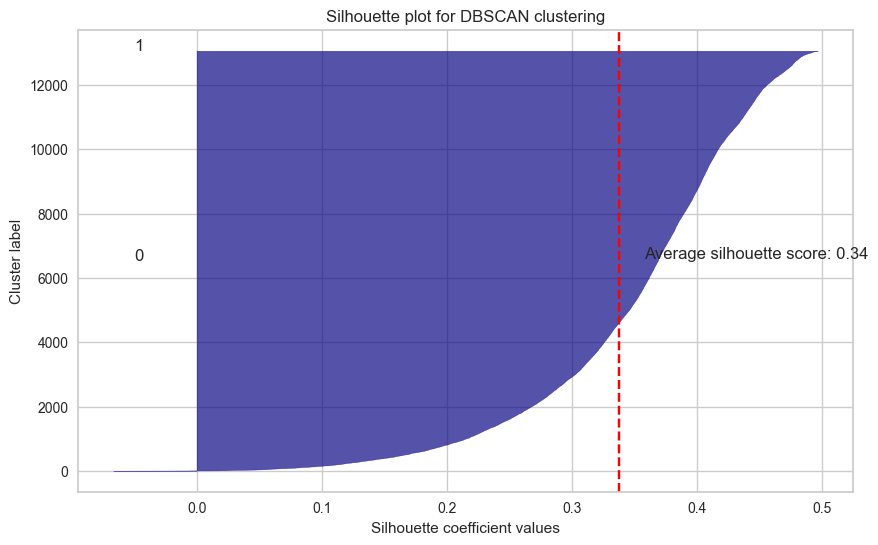

In [46]:
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(pca_result, db_labels)

# Create a bar plot to visualize silhouette scores
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(len(np.unique(db_labels))):
    # Aggregate silhouette scores for samples in cluster i
    cluster_silhouette_values = sample_silhouette_values[db_labels == i]
    cluster_silhouette_values.sort()
    size_cluster_i = cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Fill color for each cluster
    color = plt.cm.plasma(float(i) / len(np.unique(db_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label silhouette plots with cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute new y_lower for next plot
    y_lower = y_upper + 10

plt.title("Silhouette plot for DBSCAN clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")

# Annotate silhouette score
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.text(silhouette_avg + 0.02, 0.5 * len(pca_result), 'Average silhouette score: {:.2f}'.format(silhouette_avg),
         verticalalignment='center')

plt.show()

> # **The best model**
>- ### The best model is KMeans therefore we will use it to evaluate our result and understand the clusters

In [47]:
df['Label'] = kmeans_labels

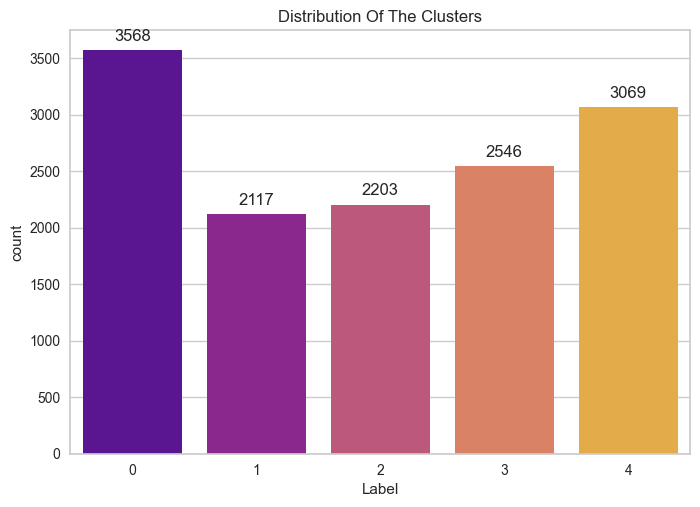

In [48]:
# Create the count plot
pl = sns.countplot(x=df["Label"], palette='plasma')
pl.set_title("Distribution Of The Clusters")

# Add count labels on top of each bar
for p in pl.patches:
    pl.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

plt.show()

In [49]:
df.head()

Cut     Polish   Symmetry  Depth%  Table%  Crownangle  Pavilion_Angle   
0  Ideal  Excellent  Excellent    60.9    56.0        35.0            40.8  \
1  Ideal  Excellent  Excellent    61.6    56.0        35.0            40.8   
2  Ideal  Excellent  Excellent    60.8    57.0        34.5            40.8   
3  Ideal  Excellent  Excellent    61.9    57.0        35.0            40.8   
4  Ideal  Excellent  Excellent    61.5    56.0        34.5            40.8   

  Eyeclean Certification  Price Color Clarity  Carat Natural Pointed Culet   
0      Yes           GIA  20795     J     VS1   2.13       1             0  \
1      Yes           GIA  19750     J     VS1   2.03       1             0   
2      Yes           GIA  11975     J     VS2   1.64       1             0   
3      Yes           GIA  51750     I     VS2   3.32       1             0   
4      Yes           GIA   9388     E     VS1   1.07       1             0   

  Fluorescence Thinest_Girdle Thickest_Girdle      L/W%  Label  
0         None           thin          medium  0.995221      2  
1        Faint         medium          medium  0.992656      2  
2         None         medium          medium  0.997382      0  
3         None         medium  slightly thick  1.002099      0  
4        Faint         medium          medium  0.996974      4

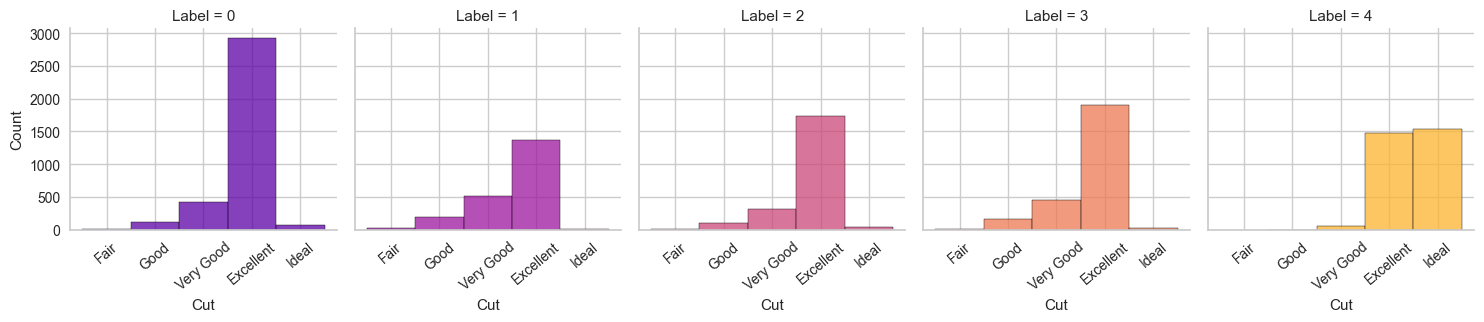

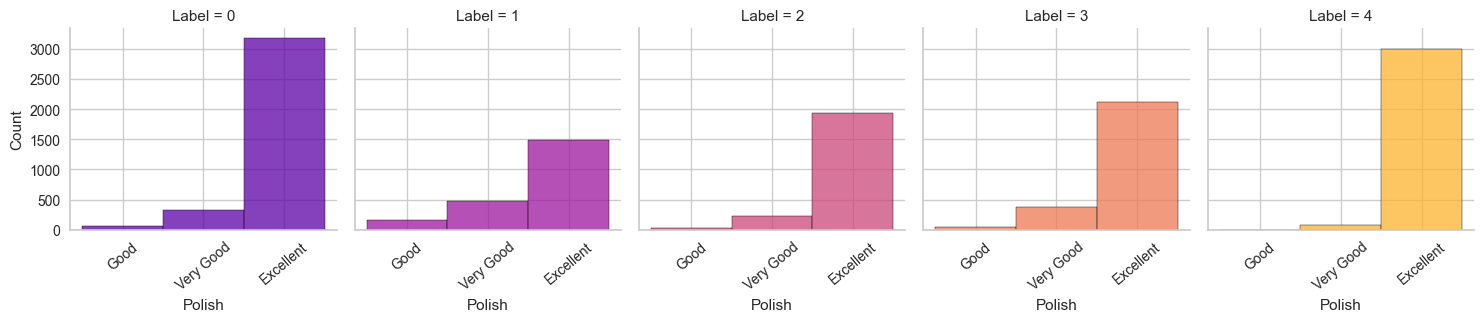

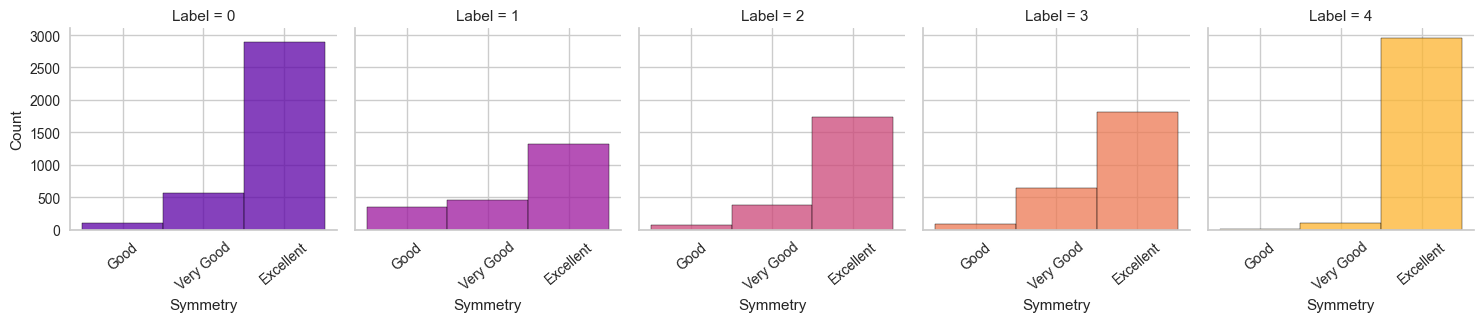

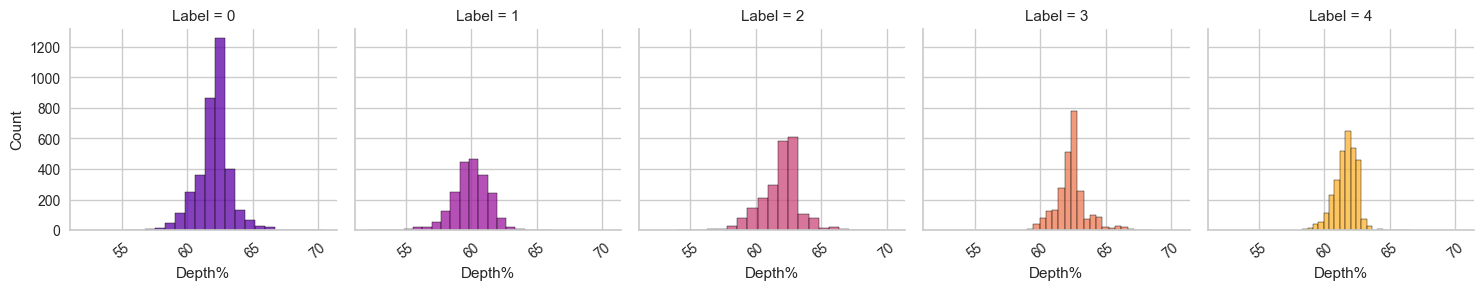

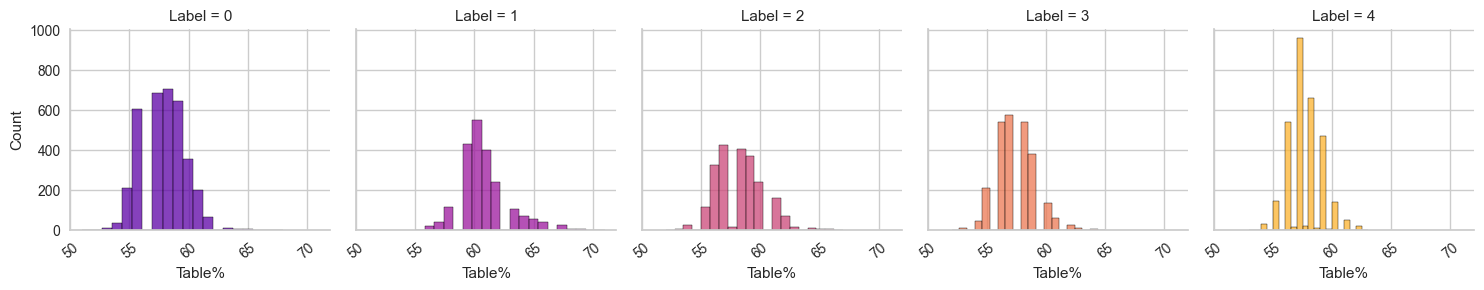

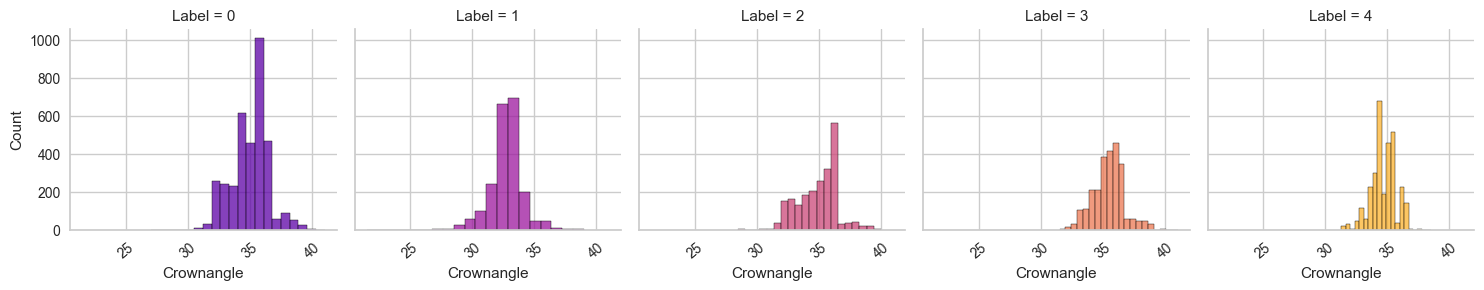

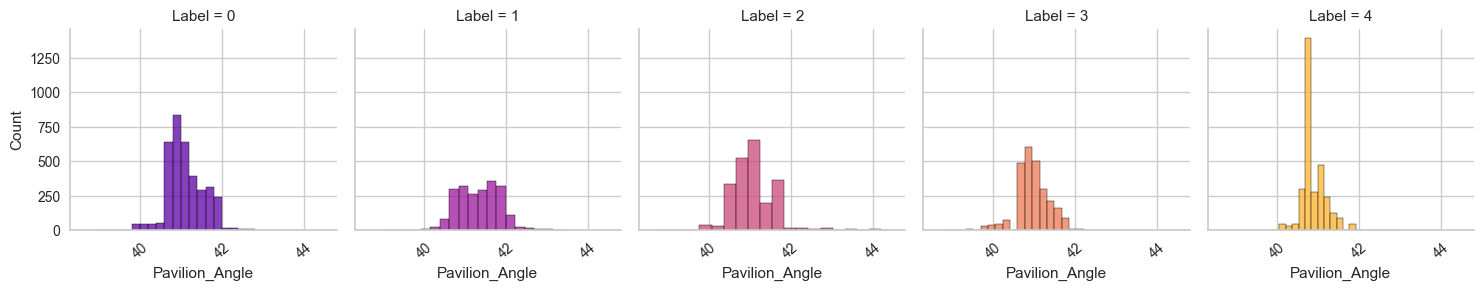

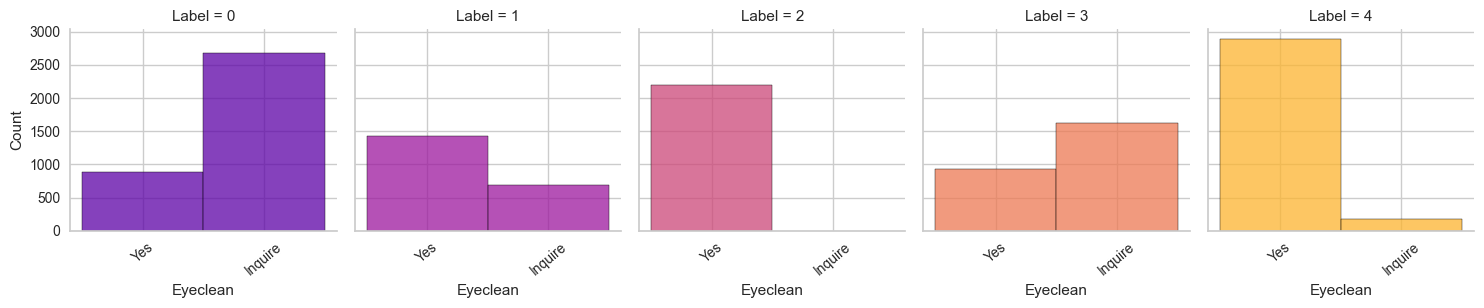

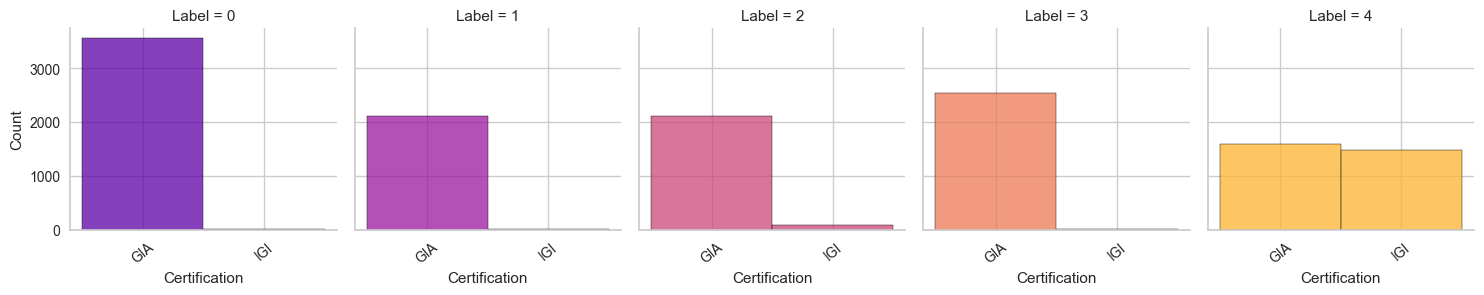

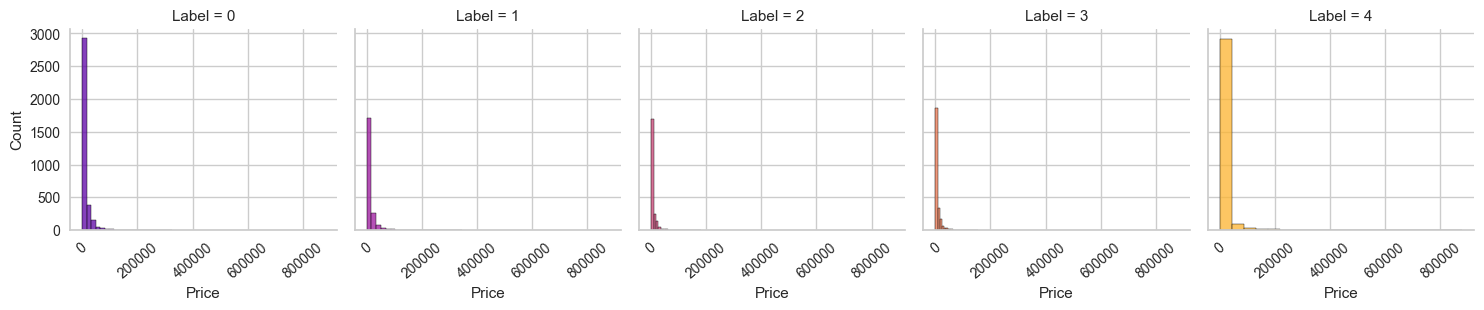

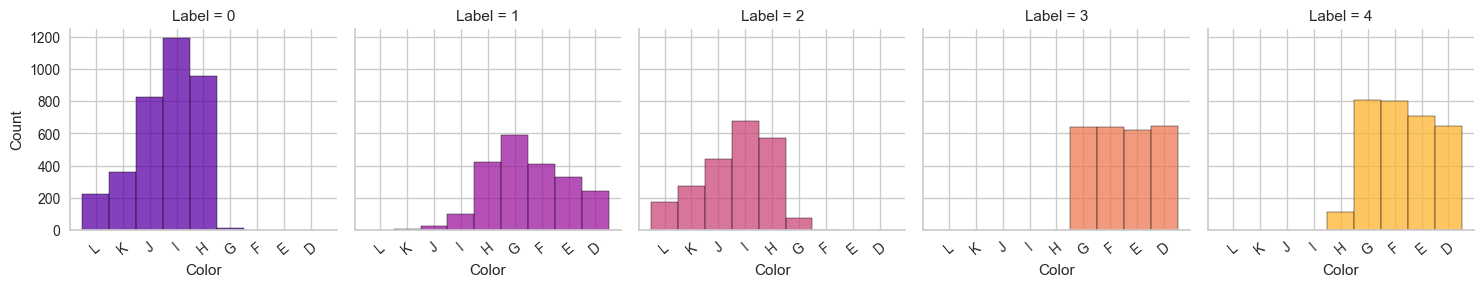

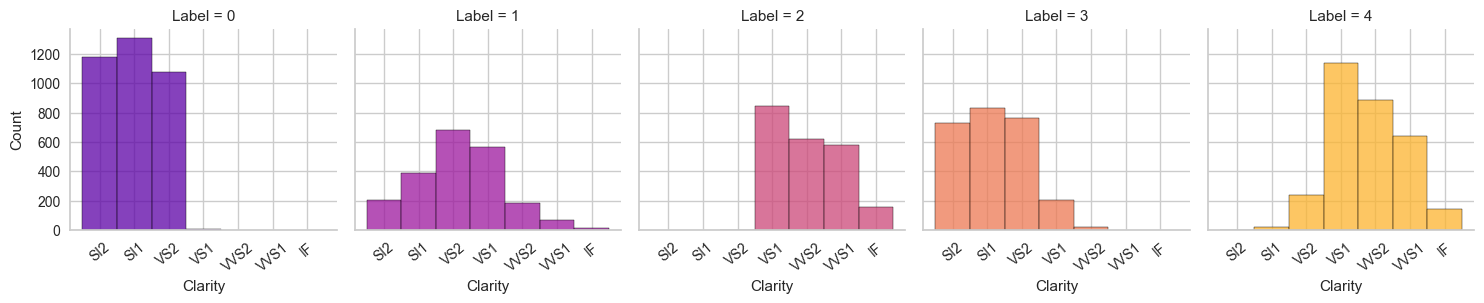

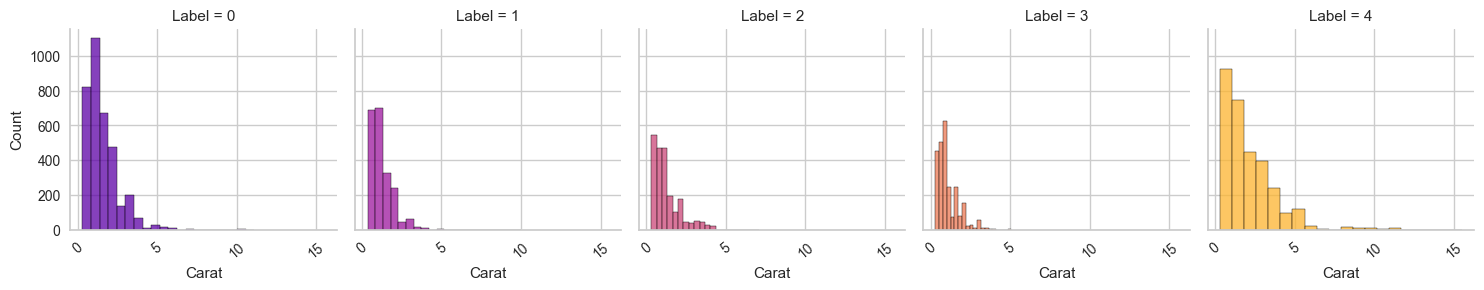

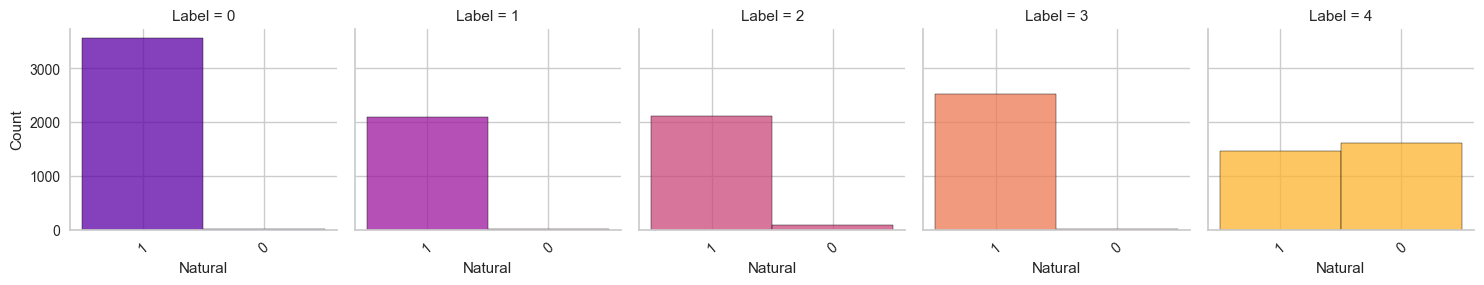

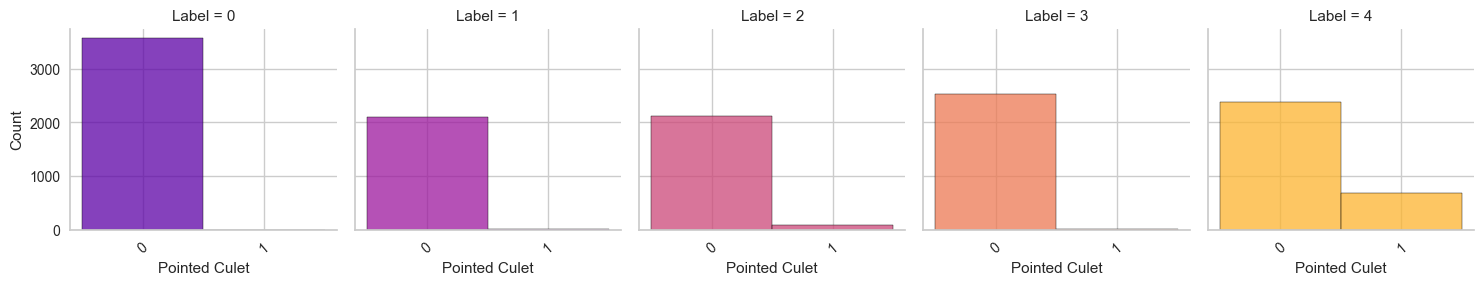

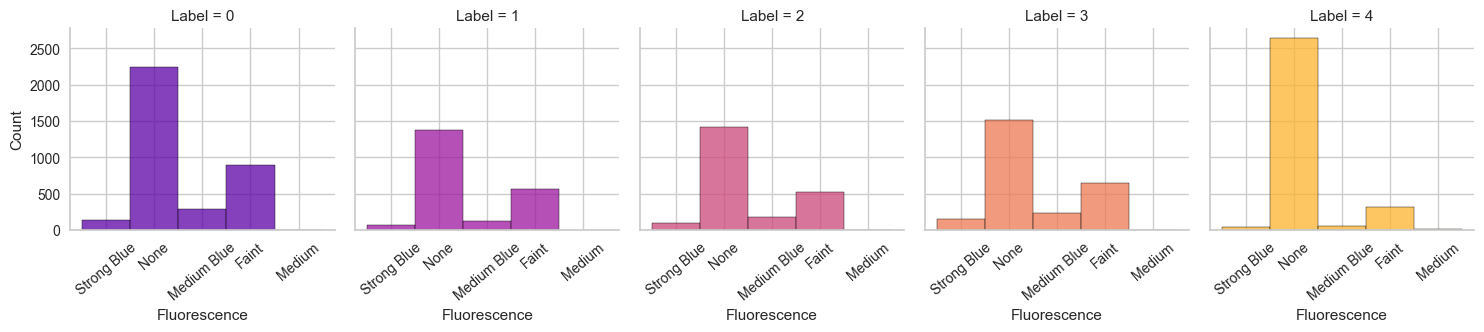

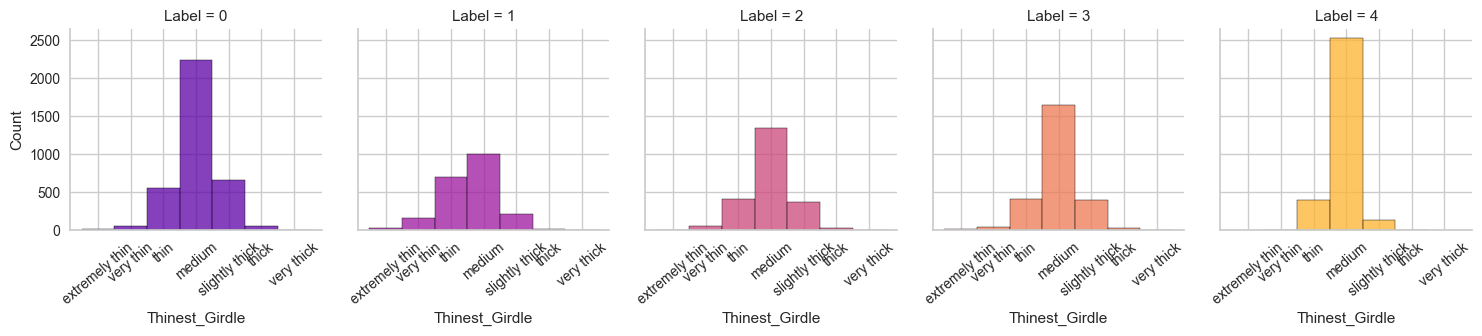

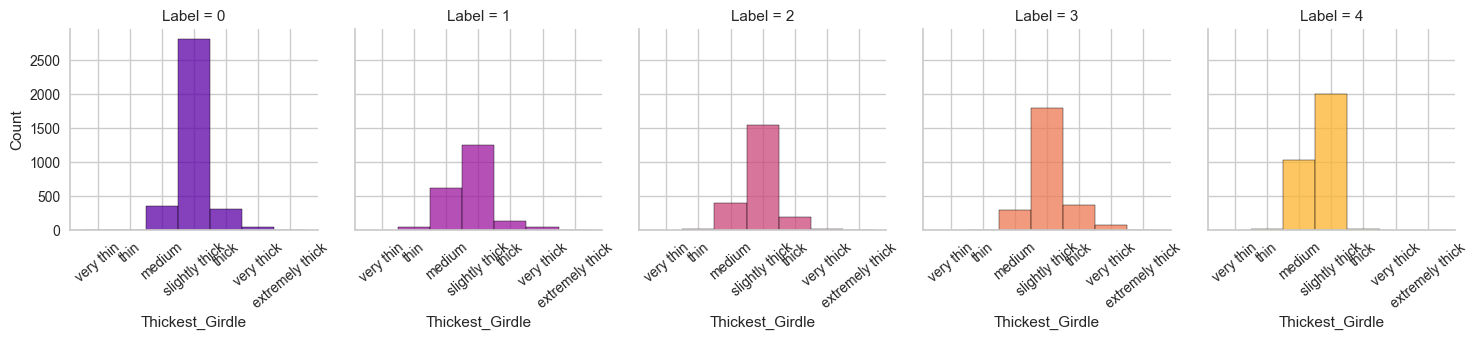

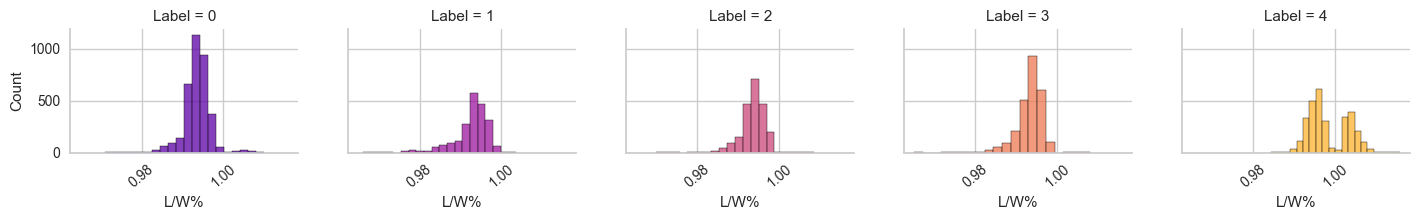

In [50]:
df_toPlot = df.copy()
for column, order in column_order.items():
    df_toPlot[column] = pd.Categorical(df_toPlot[column], categories=order, ordered=True)

# Sort DataFrame
df_toPlot = df_toPlot.sort_values(by=list(column_order.keys()))

# Get column names excluding 'Label'
columns_to_plot = [col for col in df_toPlot.columns if col != 'Label']

# Iterate through each column
for column in columns_to_plot:
    grid = sns.FacetGrid(df_toPlot, col='Label', hue='Label', palette='plasma')
    grid.map(sns.histplot, column, bins=20)

    for ax in grid.axes.flat:
                ax.tick_params(axis='x', labelrotation=40)  # Rotate x-axis labels

    
plt.subplots_adjust(wspace=0.2)
plt.tight_layout(pad=3.0)
plt.show()

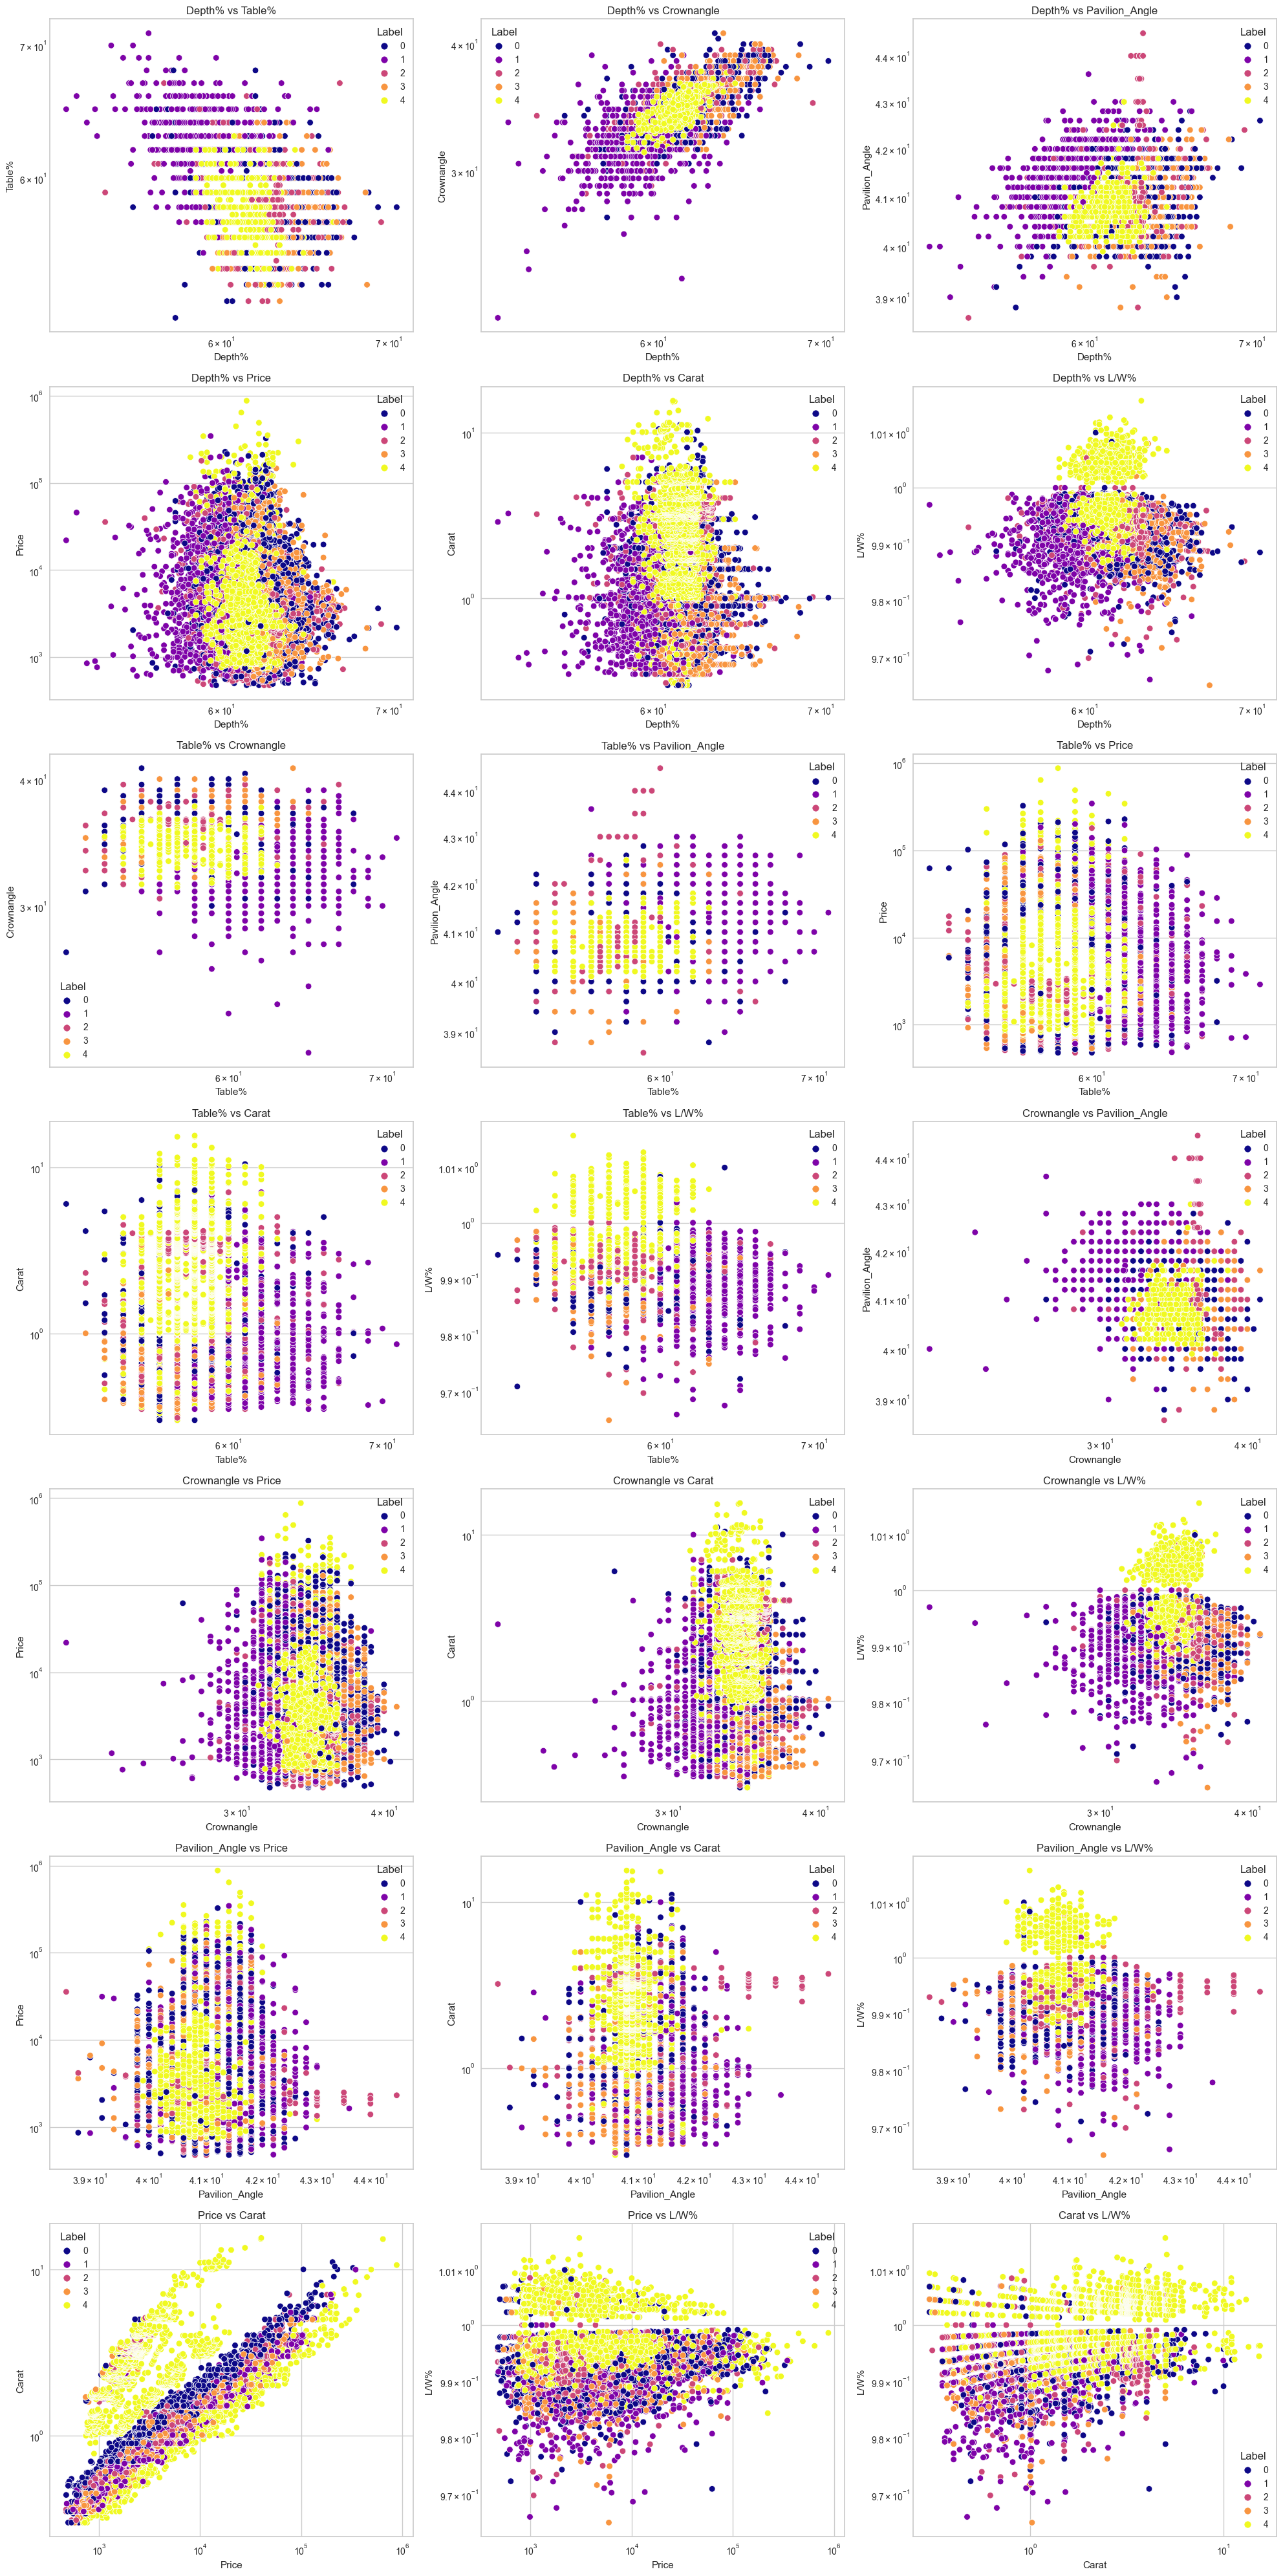

In [51]:
# Creating pairplots
column_pairs = [('Depth%', 'Table%'), ('Depth%', 'Crownangle'), ('Depth%', 'Pavilion_Angle'),
                ('Depth%', 'Price'), ('Depth%', 'Carat'), ('Depth%', 'L/W%'),
                ('Table%', 'Crownangle'), ('Table%', 'Pavilion_Angle'), ('Table%', 'Price'),
                ('Table%', 'Carat'), ('Table%', 'L/W%'),
                ('Crownangle', 'Pavilion_Angle'), ('Crownangle', 'Price'), ('Crownangle', 'Carat'),
                ('Crownangle', 'L/W%'),
                ('Pavilion_Angle', 'Price'), ('Pavilion_Angle', 'Carat'), ('Pavilion_Angle', 'L/W%'),
                ('Price', 'Carat'), ('Price', 'L/W%'),
                ('Carat', 'L/W%')]

# Create subplots
fig, axes = plt.subplots(7, 3, figsize=(20, 40))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, pair in enumerate(column_pairs):
    x_col, y_col = pair
    # Apply logarithmic transformation to both axes
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='Label', ax=axes[i], palette=plasma)
    axes[i].set_title(f'{x_col} vs {y_col}')

# Adjust layout
plt.tight_layout()
plt.show()